# 0.0. IMPORTS

In [1]:
import pandas as pd
import inflection
import math
import numpy as np
import pickle
import seaborn as sns
import datetime
import socket
from boruta import BorutaPy
import xgboost as xgb

import scipy
from scipy import stats as ss

import sklearn
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso

import matplotlib 
from matplotlib import gridspec as gridspec
from matplotlib import pyplot as plt

from IPython.core.display import HTML
from IPython.display import Image

import pylab
pylab.rcParams['figure.figsize'] = (20.0, 20.0)

import warnings
warnings.filterwarnings('ignore')

import chameleon 
import bleach
import bokeh
import random

## 0.1. Helper Functions

In [2]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 ) 
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )


def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )
     
    
def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )

    
def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name, 
                           'MAE': mae, 
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )

def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )



def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

## 0.2. Loading data

In [3]:
df_sales_raw = pd.read_csv( 'data/train.csv' , low_memory=False )
df_store_raw = pd.read_csv( 'data/store.csv' , low_memory=False )

# merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store')

In [4]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
596970,116,7,2014-01-12,0,0,0,0,0,0,a,a,680.0,4.0,2013.0,0,NaN,NaN,NaN


# 1.0. DESCRIÇÃO DOS DADOS

In [5]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
           'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
           'CompetitionDistance', 'CompetitionOpenSinceMonth',
           'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
           'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map( snakecase, cols_old))

#rename
df1.columns = cols_new

# 1.2 Data Dimensions

In [7]:
print( 'Number of rows : {}'.format( df1.shape[0]))
print( 'Number of cols : {}'.format( df1.shape[1]))

Number of rows : 1017209
Number of cols : 18


# 1.3 Data Types

In [8]:
df1['date'] = pd.to_datetime( df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

# 1.4 Check NA 

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

# 1.5. Fillout NA

In [10]:
#competition_distance 
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month 
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year     
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#promo2_since_week  
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year 
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval 
month_app = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_app)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply (lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [11]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

# 1.6. Change Types

In [12]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

# 1.7. Descriptive Statistical

In [13]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'])

## 1.7.1 Numeriacal Attributes

In [14]:
# Central Tendency - Mean, Median
ct1 = pd.DataFrame( num_attributes.apply ( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply ( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std) ).T
d2 = pd.DataFrame( num_attributes.apply(min ) ).T
d3 = pd.DataFrame( num_attributes.apply(max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ( [ 'attributes', 'min' , 'max' , 'range' , 'mean' , 'median' , 'std' , 'skew', 'kurtosis' ] )

In [15]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,promo2,0.0,1.0,1.0,0.500564,1.0,0.500000,-0.002255,-1.999999
9,is_promo,0.0,1.0,1.0,0.155231,0.0,0.362124,1.904152,1.625796


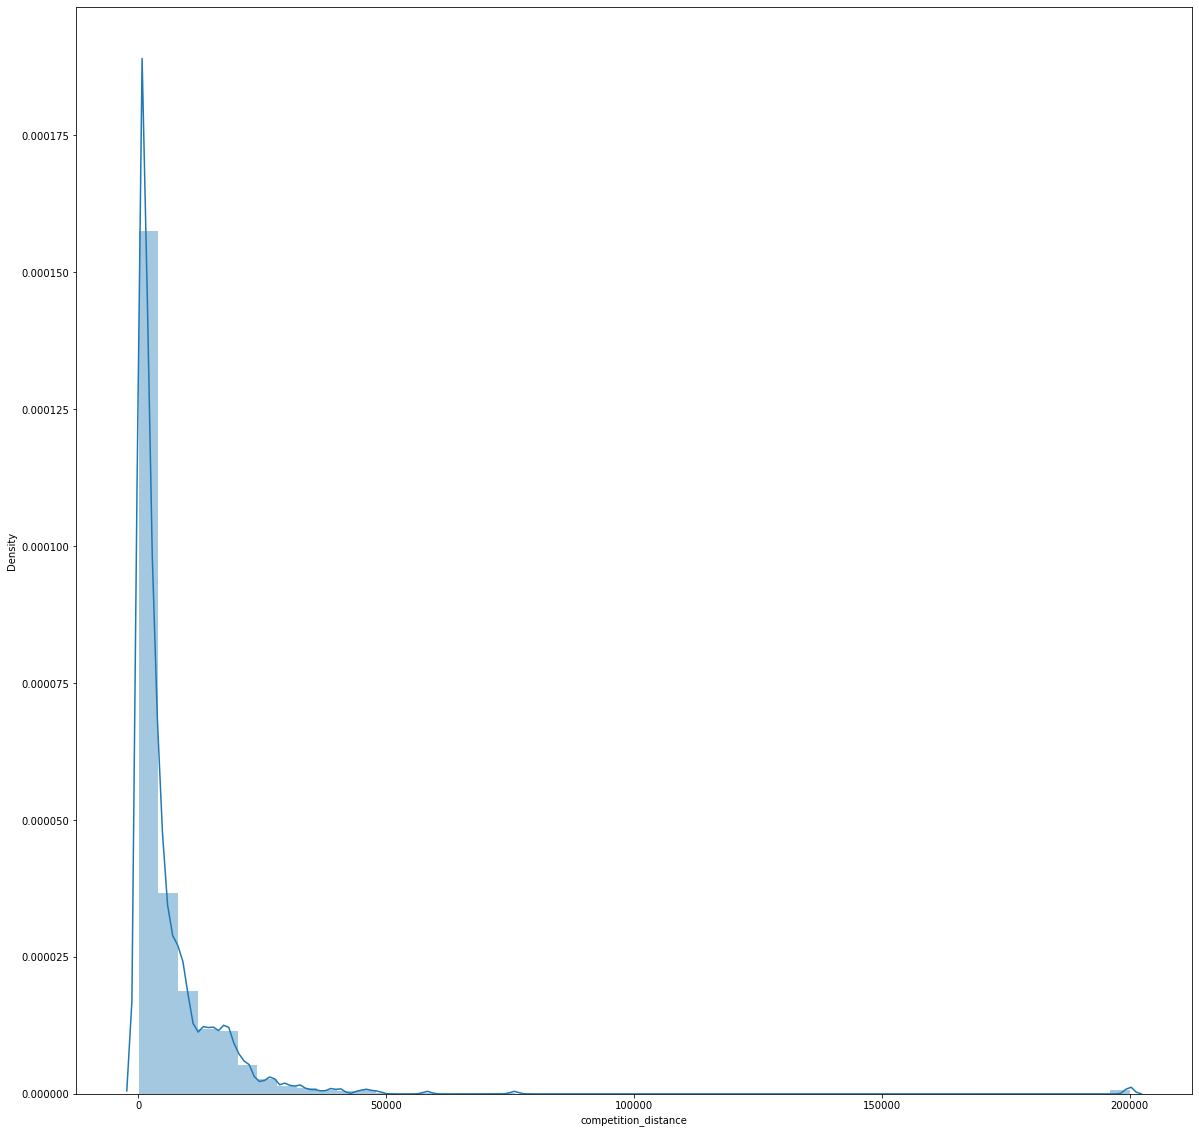

In [16]:
sns.distplot( df1['competition_distance'] );

# 1.7.2 Categorical Attributes

In [17]:
cat_attributes.apply( lambda x: x.unique().shape[0])

state_holiday                    4
store_type                       4
assortment                       3
competition_open_since_month    12
competition_open_since_year     23
promo2_since_week               52
promo2_since_year                7
promo_interval                   4
month_map                       12
dtype: int64

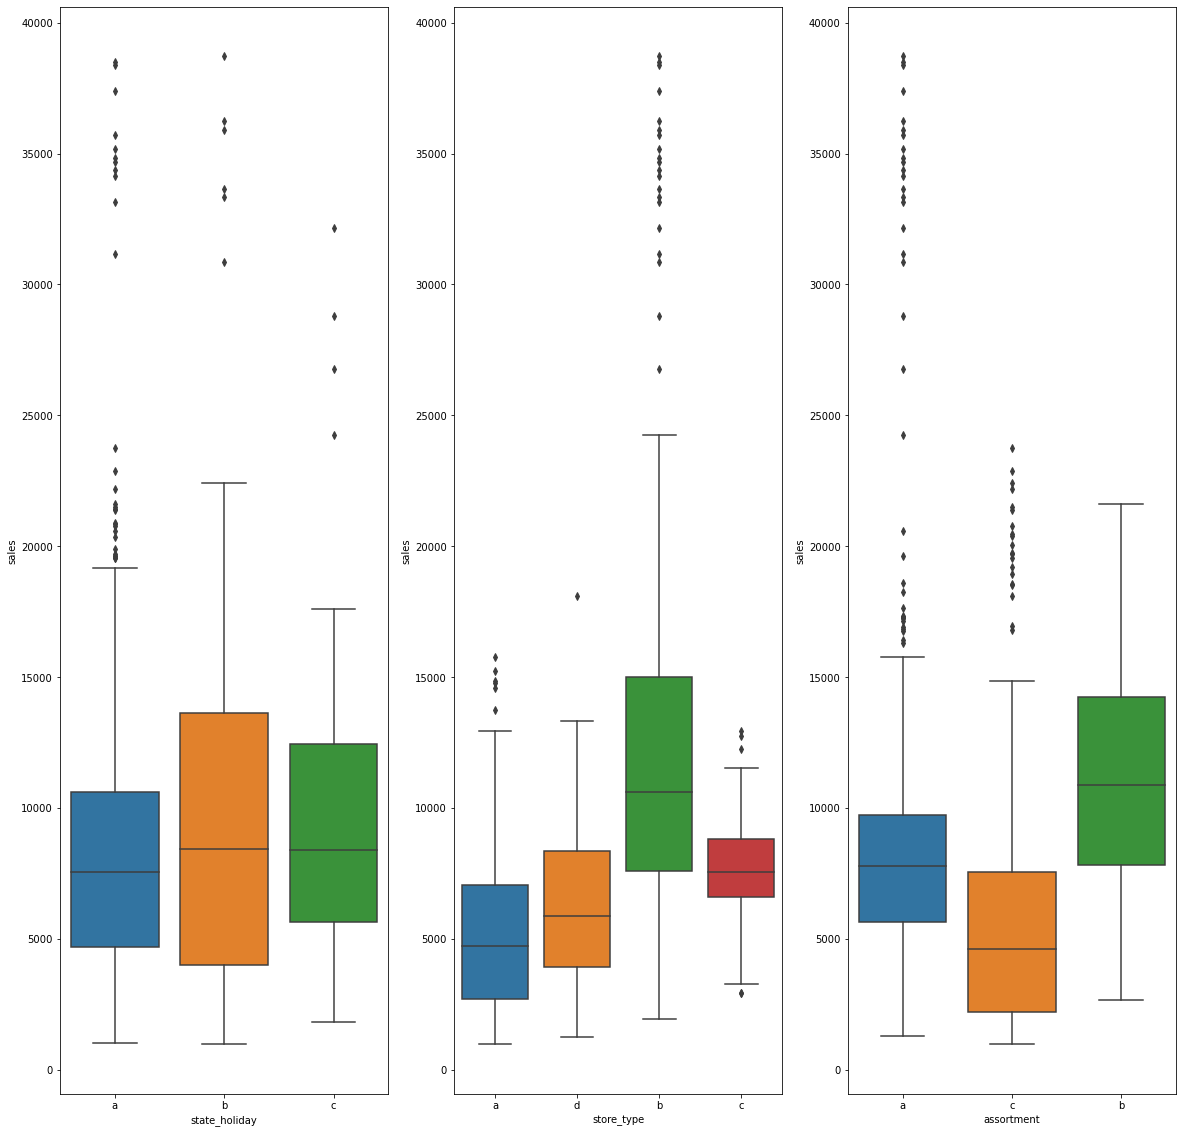

In [18]:
aux1 = df1[( df1['state_holiday'] != '0' ) & (df1['sales'] > 0 )]

plt.subplot( 1, 3, 1)
sns.boxplot( x='state_holiday' , y='sales' , data=aux1 )

plt.subplot( 1, 3, 2)
sns.boxplot( x='store_type' , y='sales' , data=aux1 )

plt.subplot( 1, 3, 3)
sns.boxplot( x='assortment' , y='sales' , data=aux1 );

# 2.0. FEATURE ENGINEERING

In [19]:
df2 = df1.copy()

# 2.1. Mapa Mental de Hipoteses 

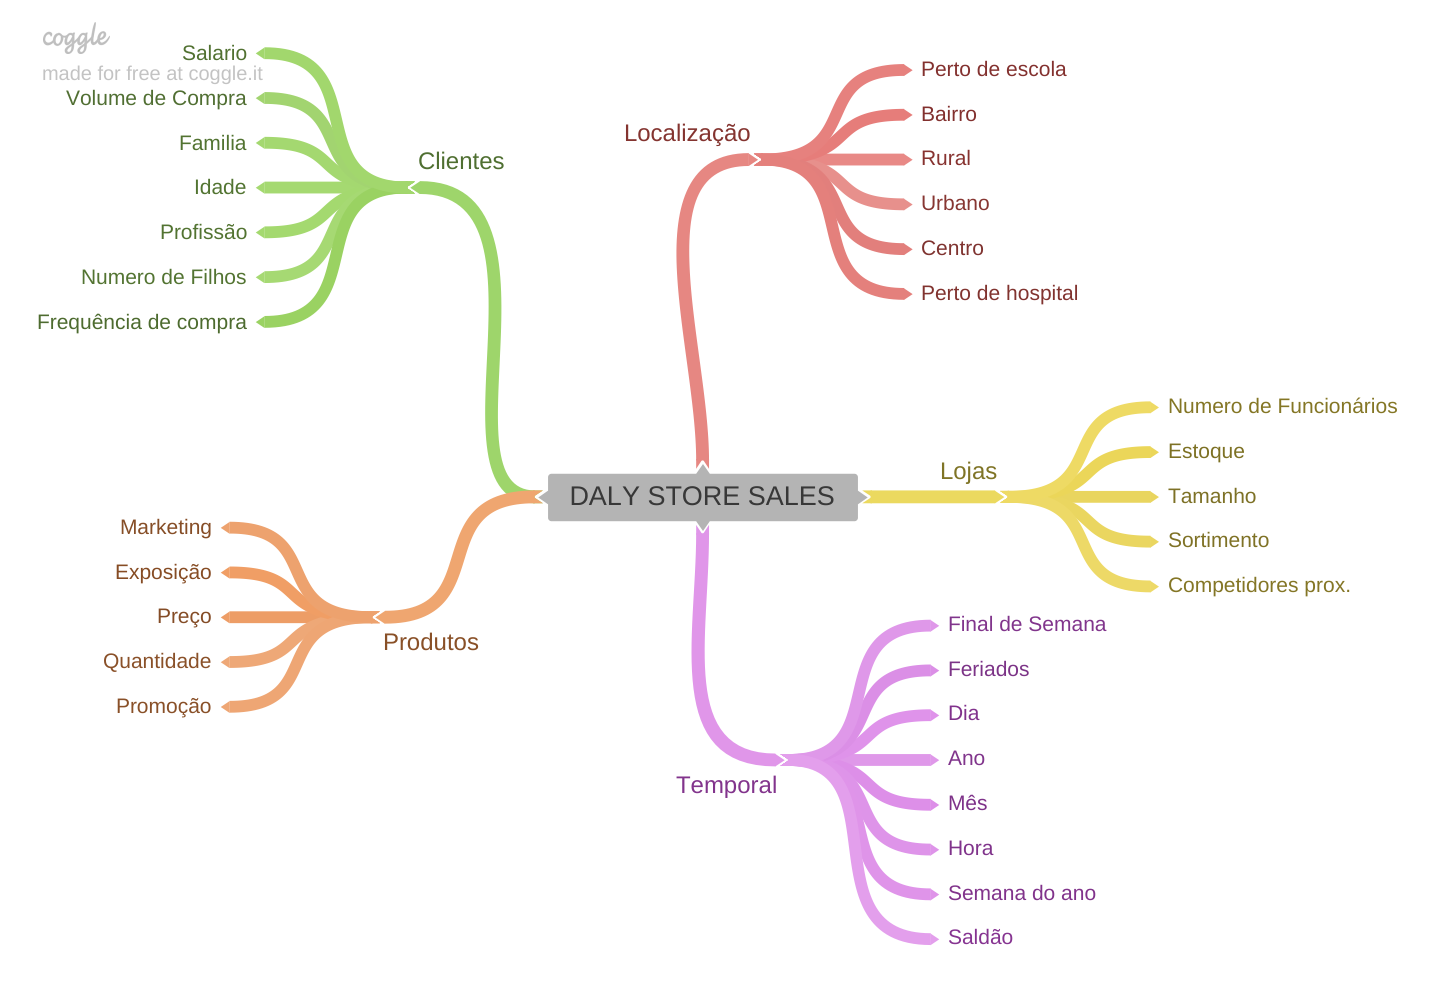

In [20]:
Image( 'img/MindMapHypothesis.jpg' )

## 2.1. Criação das Hipoteses

### 2.1.1. Hipoteses Loja

**1.** Lojas com maior quadro de funcionários deveriam vender mais.

**2.** Lojas com maior estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com menor porte deveriam vender menos.

**5.** Lojas com maior sortimento deveriam vender mais.

### 2.1.2. Hipoteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas que expoe mais o produtos nas vitrines deveriam vender mais.

**3.** Lojas que tem preços menores nos produtos deveriam vender mais.

**4.** Lojas que tem preços menores por mais tempos nos produtos deveriam vender mais.

### 2.1.3. Hipoteses Tempo

**1.** Lojas que tem mais feriados deveriam vender menos.

**2.** Lojas que abrem nos primeiros 6 meses deveriam vender mais.

**3.** Lojas que abrem nos finais de semana deveriam vender mais.

## 2.2. Lista Final de Hipóteses

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menor.

**3.** Lojas com competidores à mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

# 2.3. Feature Engineering

In [21]:
# year
df2['year'] = df2['date'].dt.year
# month
df2['month'] = df2['date'].dt.month
# day
df2['day'] = df2['date'].dt.day
# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week
#yeah week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30 ) .apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply (lambda x:datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

#assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

#state holidday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')


In [22]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. FILTRAGEM DE VARIAVÉIS

In [23]:
df3 = df2.copy()

In [24]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1. Filtragem das Linhas

In [25]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Seleção das Colunas

In [26]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

In [27]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0. ANALISE EXPLORATORIA DOS DADOS

In [28]:
df4 = df3.copy()

## 4.1. Analise Univariada

### 4.1.1. Response Variable

<AxesSubplot:xlabel='sales', ylabel='Density'>

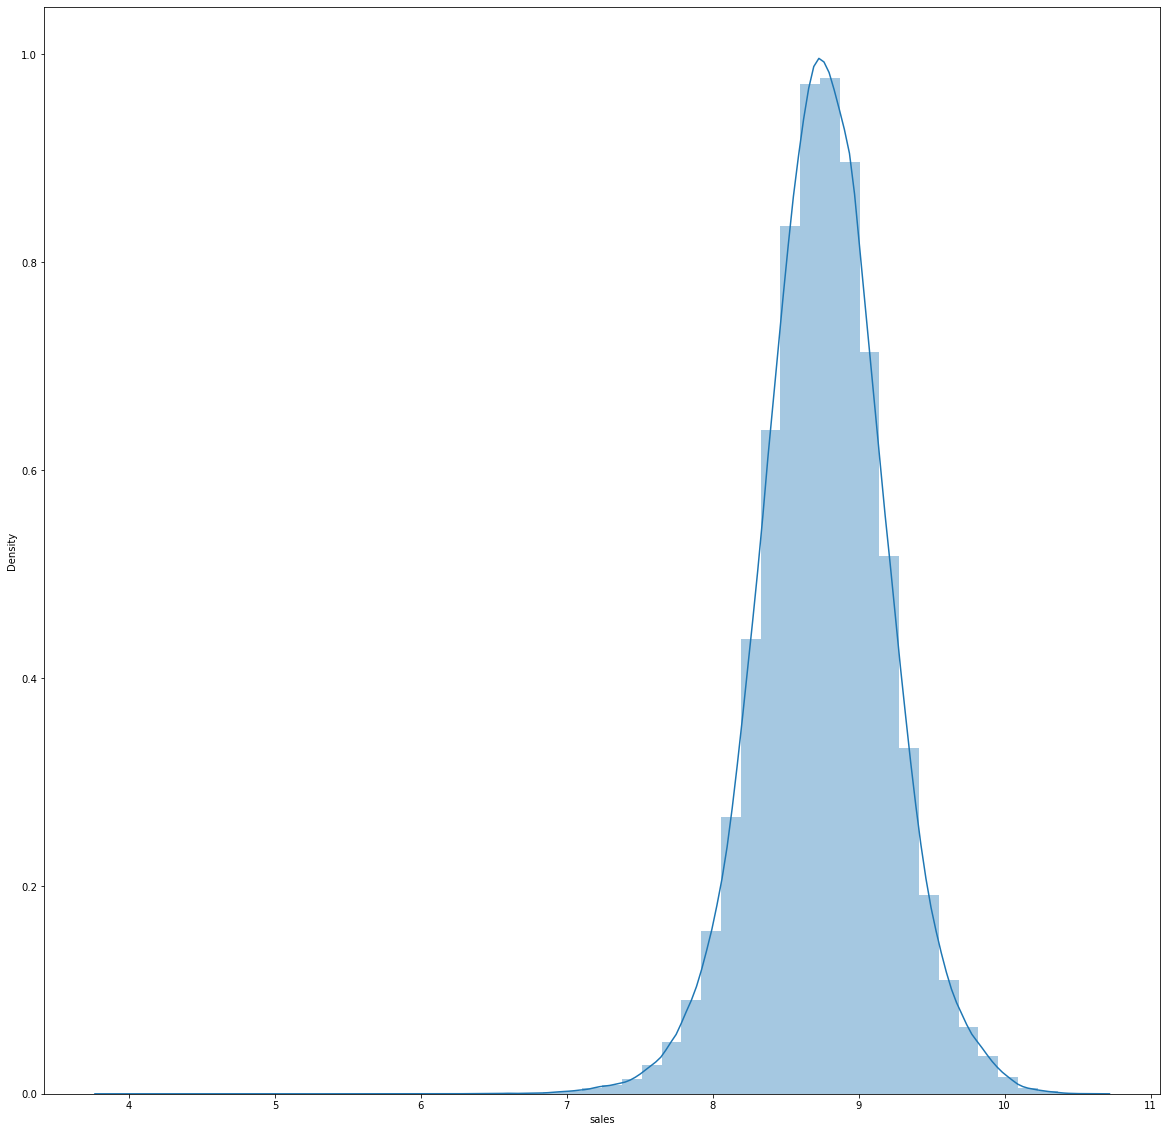

In [29]:
sns.distplot(np.log1p( df4['sales'] ) )

### 4.1.2. Numerical Variable


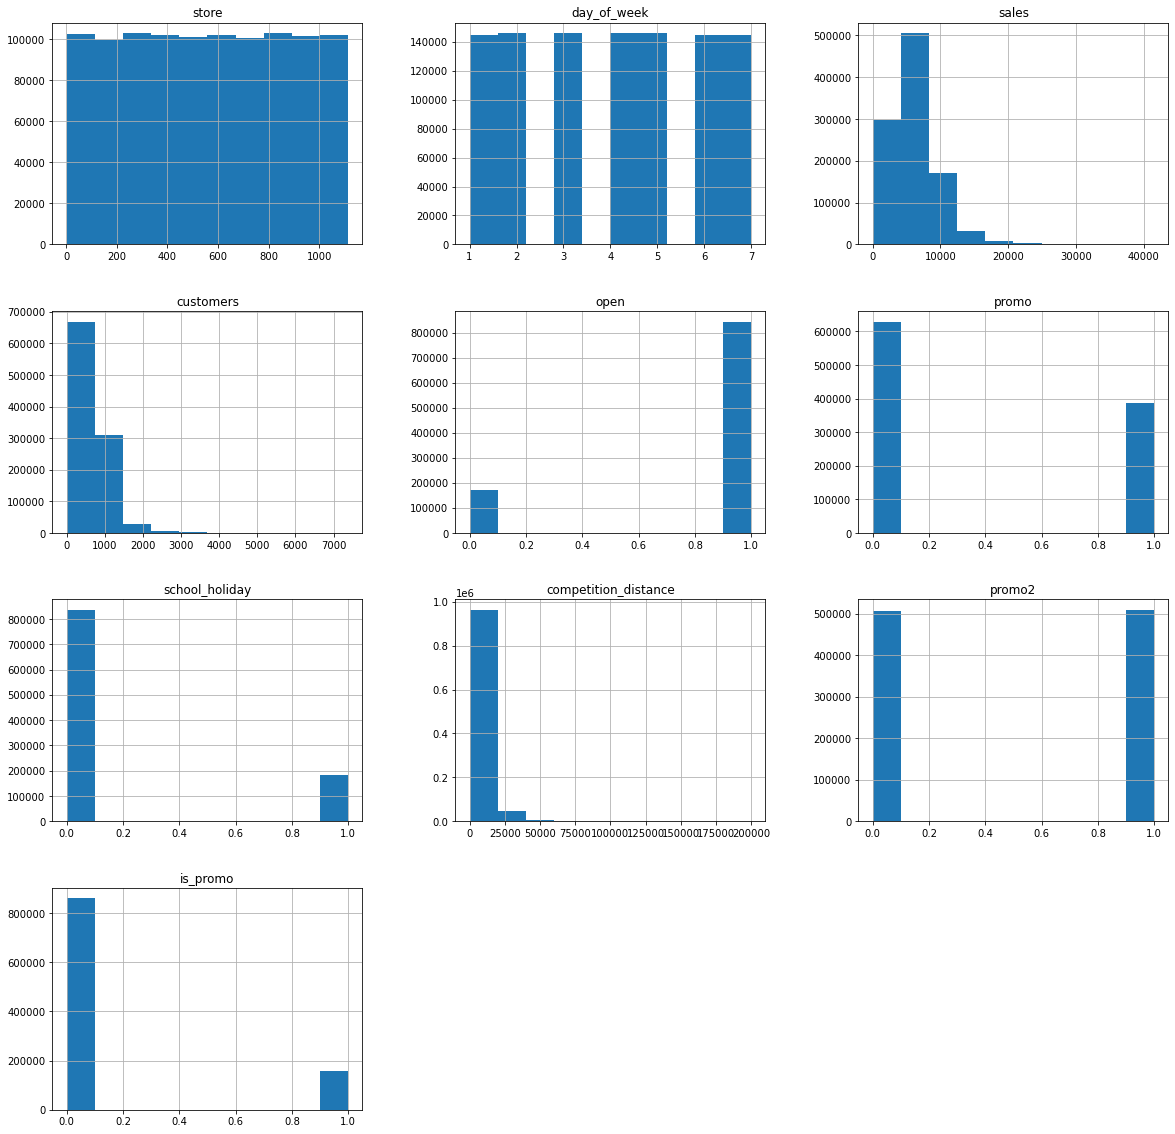

In [30]:
num_attributes.hist();

### 4.1.3. Categorical Variable

In [31]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

<AxesSubplot:xlabel='sales', ylabel='Density'>

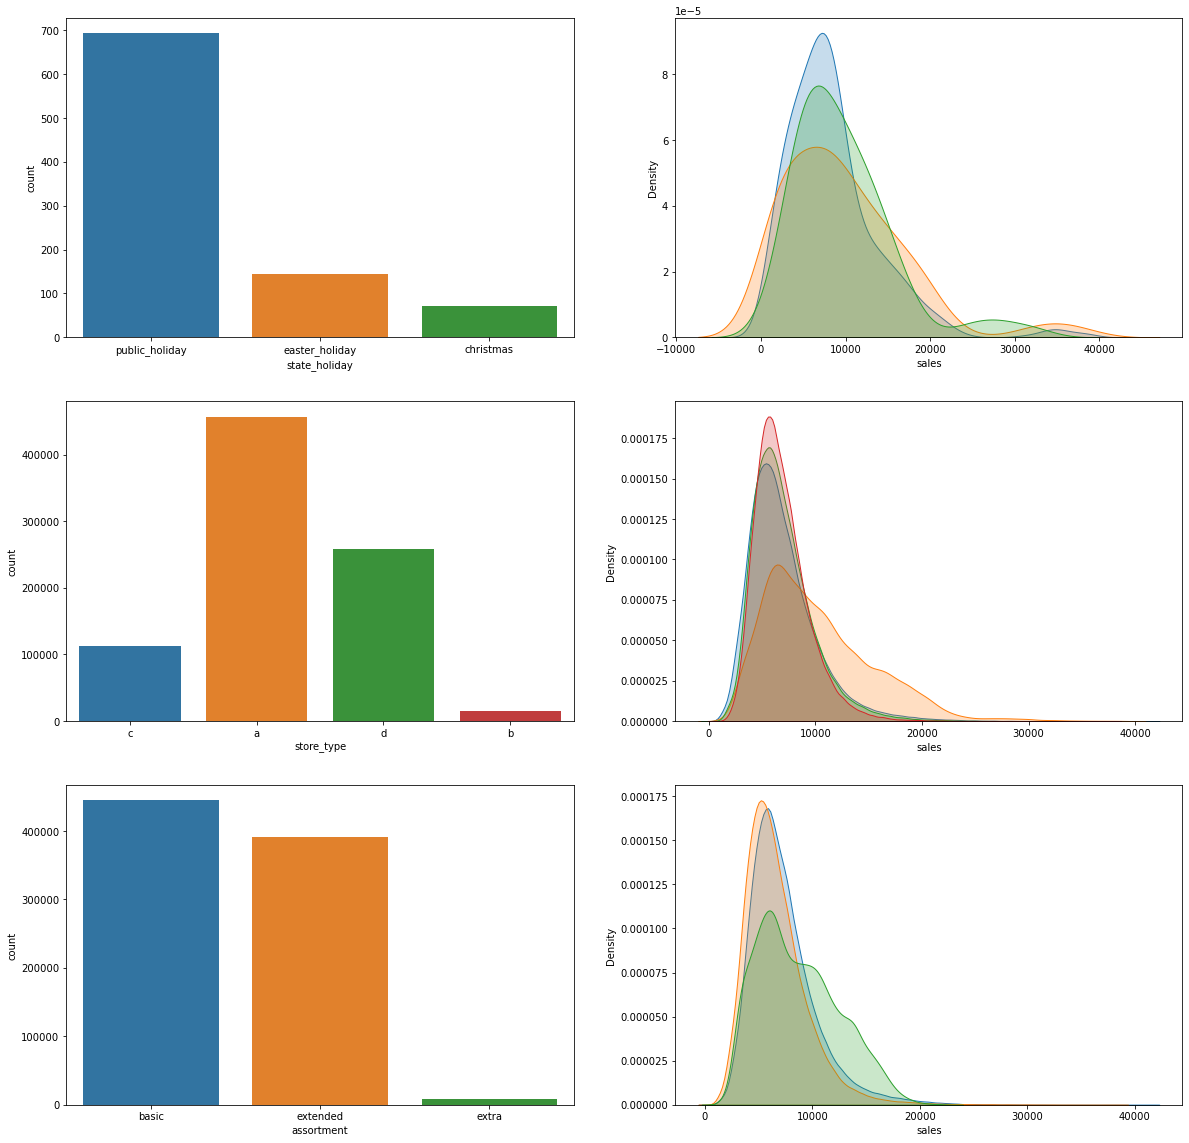

In [32]:
# state_holiday
plt.subplot( 3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday'] )

plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True )

# store_type
plt.subplot( 3, 2, 3 )
sns.countplot( df4['store_type'] )

plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True )

# assortment
plt.subplot( 3, 2, 5 )
sns.countplot( df4['assortment'] )

plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True )


## 4.2. Analise Bivariada 

### **H1.** Lojas com maior sortimentos deveriam vender mais.
***FALSA***  Lojas com MAIOR SORTIMENTO vendem MENOS.

<AxesSubplot:xlabel='year_week'>

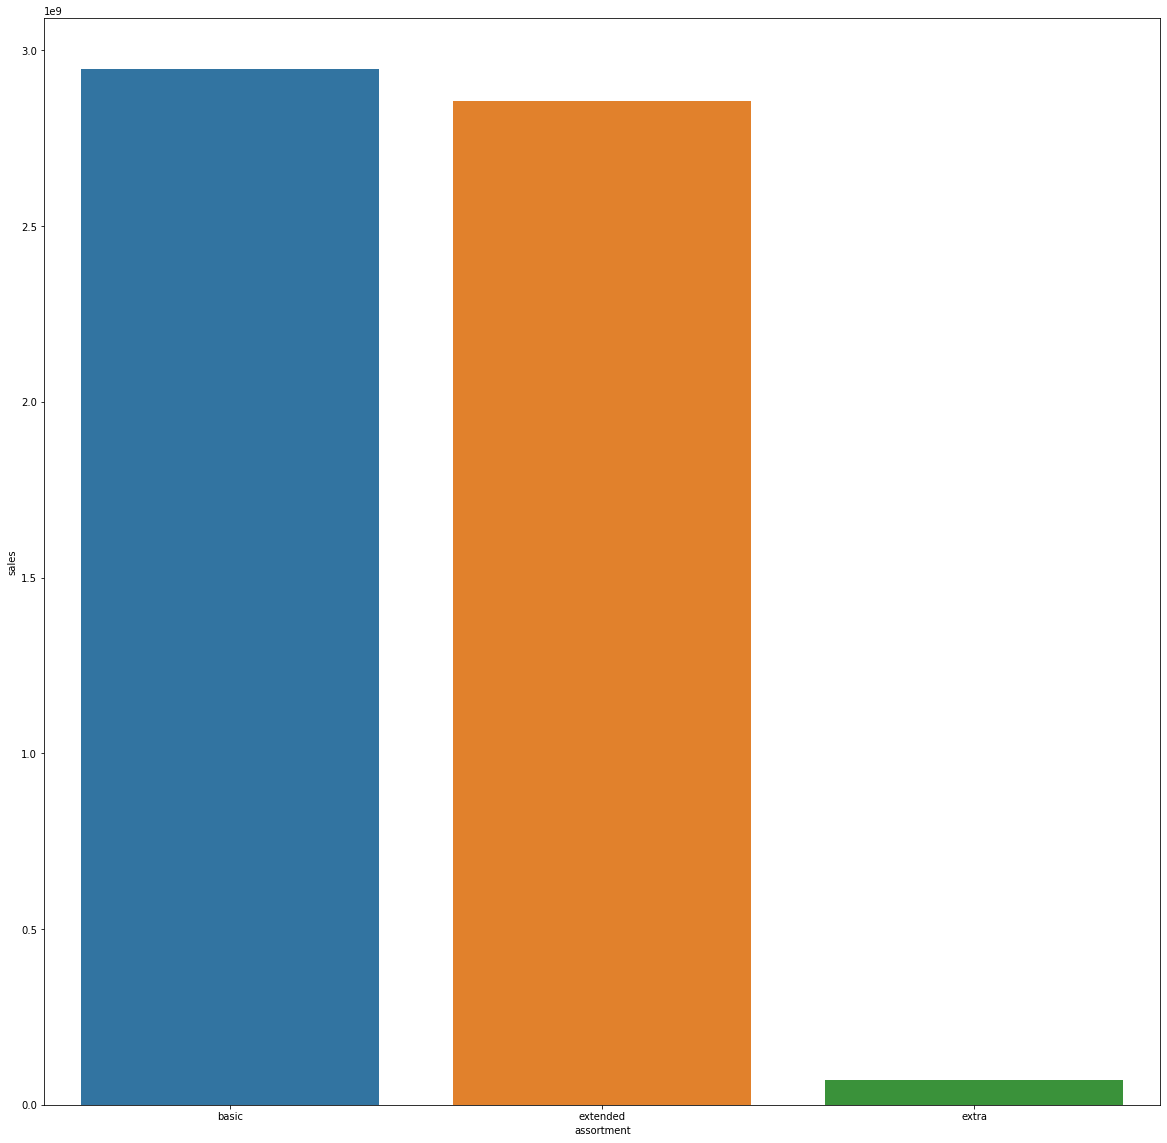

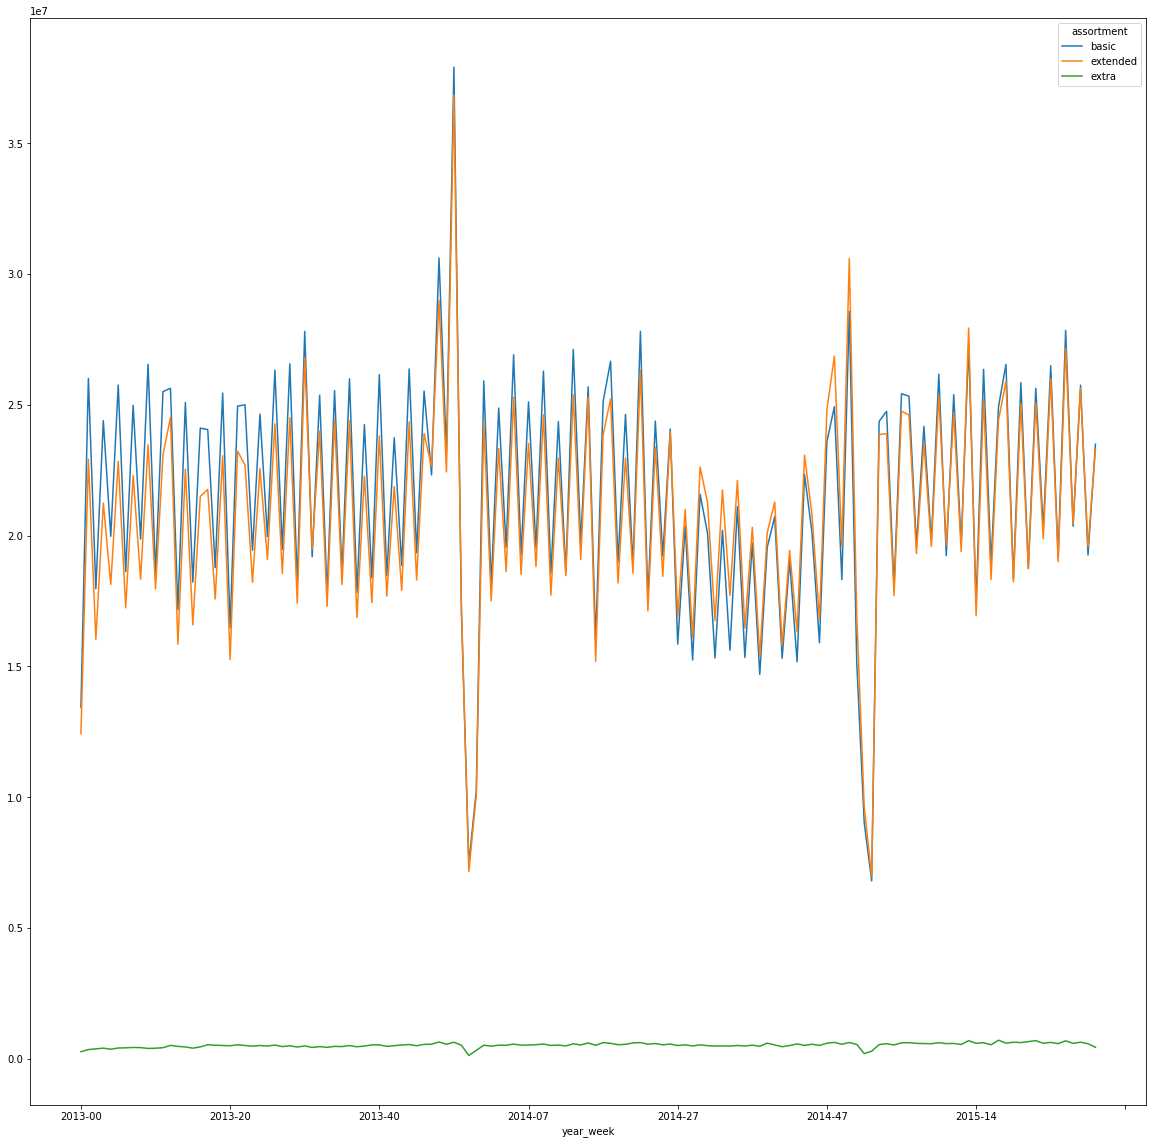

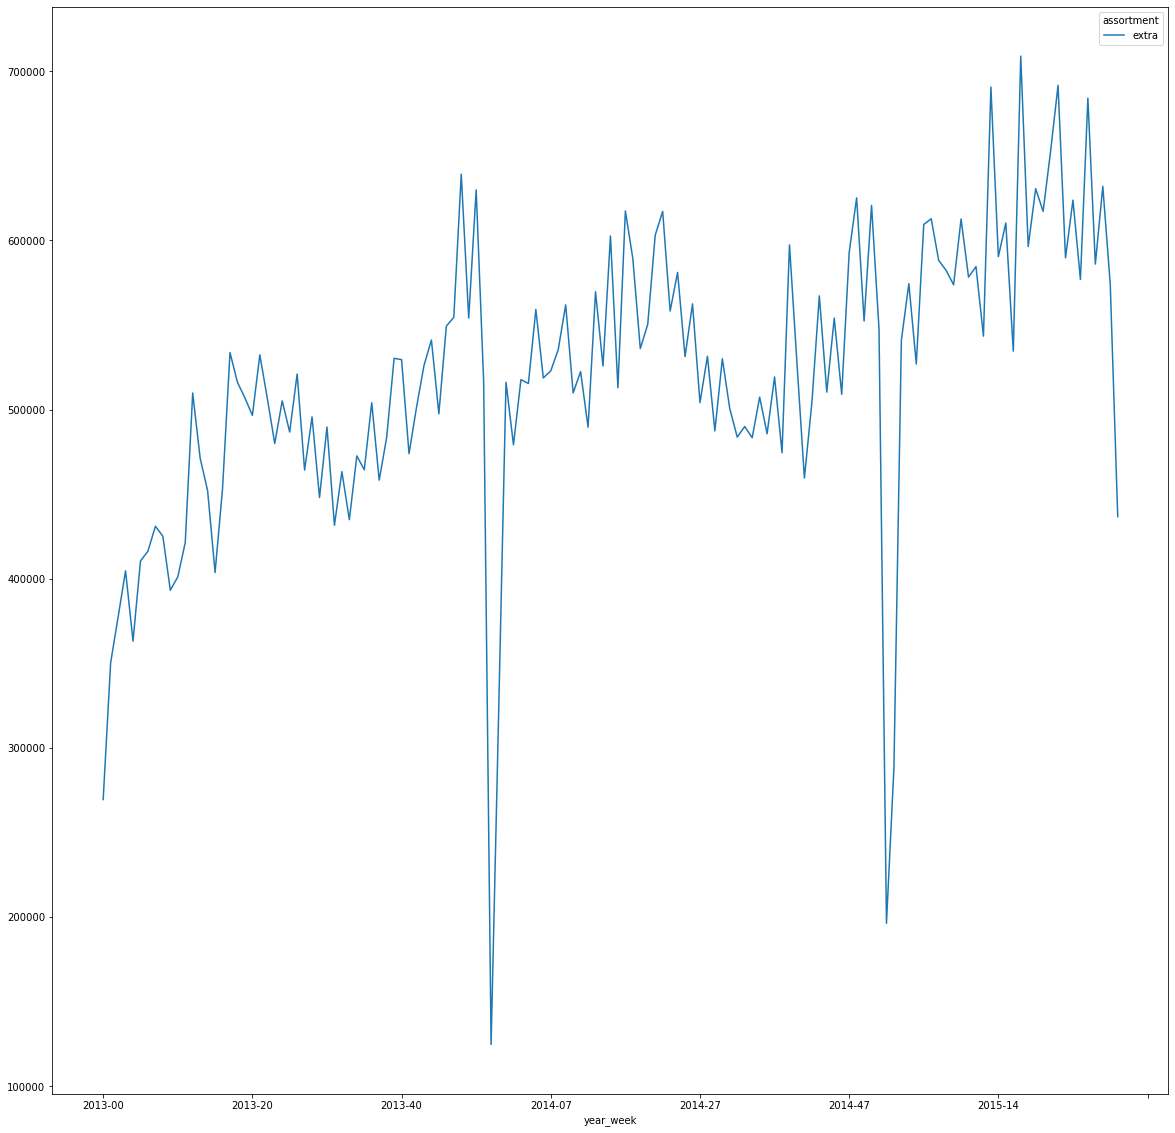

In [33]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

aux2 = df4[['year_week','assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot()

In [34]:
aux3.head()

,year_week,assortment,sales
2,2013-00,extra,269404
5,2013-01,extra,350279
8,2013-02,extra,377207
11,2013-03,extra,404662
14,2013-04,extra,363061


### **H2.** Lojas com competidores mais próximos deveriam vender menor.
***FALSA*** Lojas com COMPETIDORES MAIS PROZIMOS vendem MAIS.

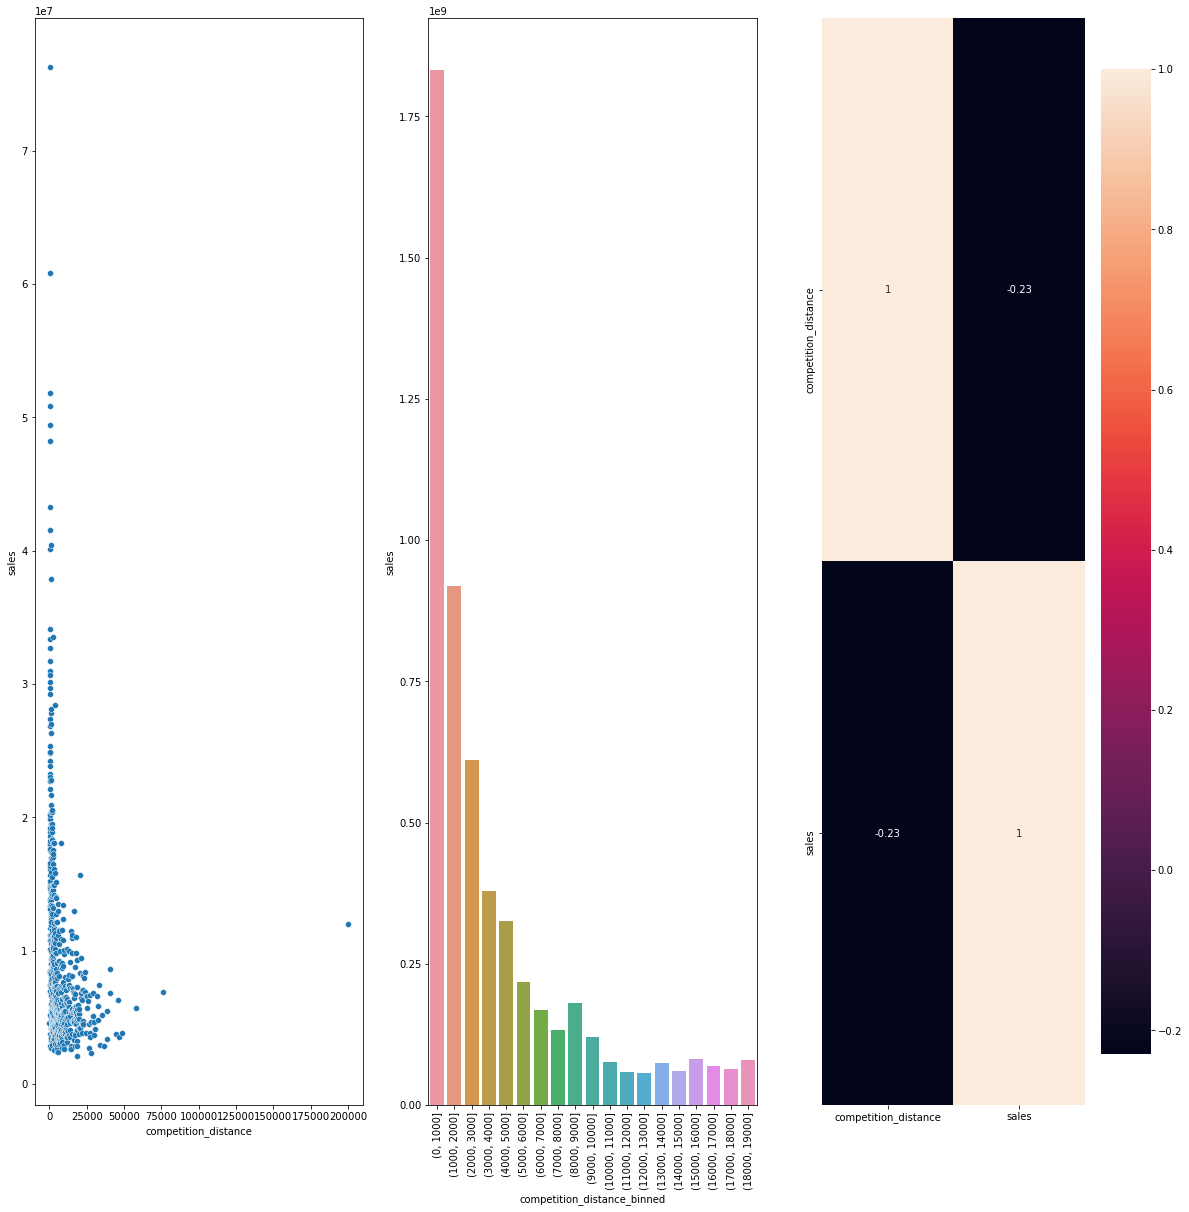

In [35]:
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance').sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(x = 'competition_distance', y= 'sales', data=aux1);

plt.subplot(1, 3, 2)
bins = list( np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned').sum().reset_index()
plt.xticks( rotation=90);

sns.barplot( x= 'competition_distance_binned', y='sales', data=aux2);

plt.subplot(1, 3, 3)
sns.heatmap( aux1.corr( method ='pearson'), annot=True);


### **H3.** Lojas com competidores à mais tempo deveriam vender mais.
***FALSA*** Lojas com COMPETIDORES RECENTES vendem MAIS.

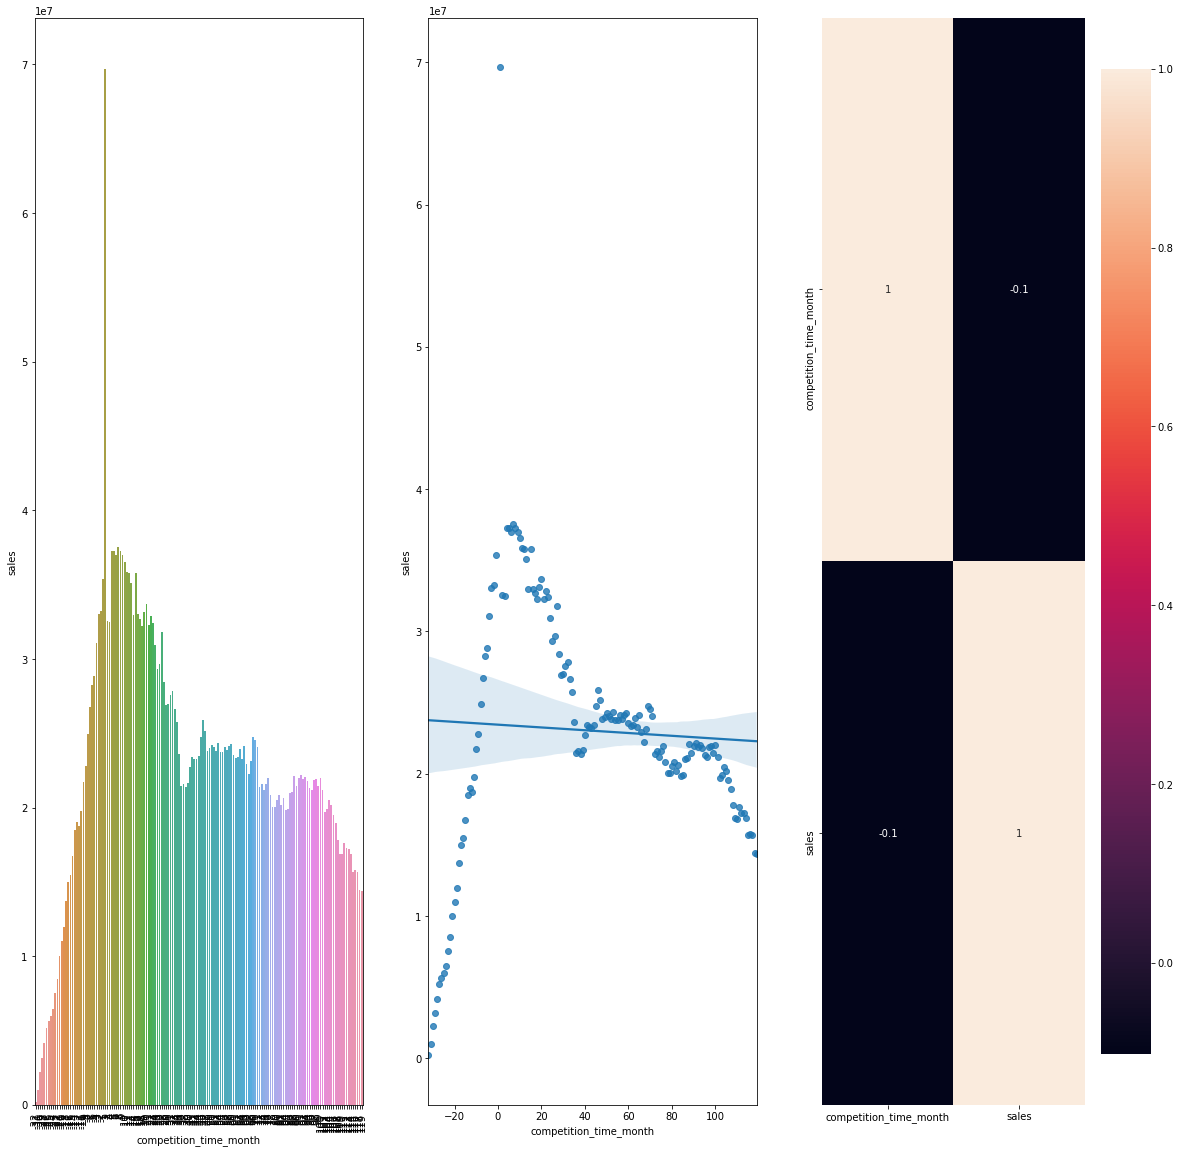

In [36]:
plt.subplot(1, 3, 1)
aux1 = df4[['competition_time_month','sales']].groupby( 'competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.
***FALSA*** Lojas com PROMOÇÕES ATIVAS por MAIS TEMPOS VENDEM MENOS.

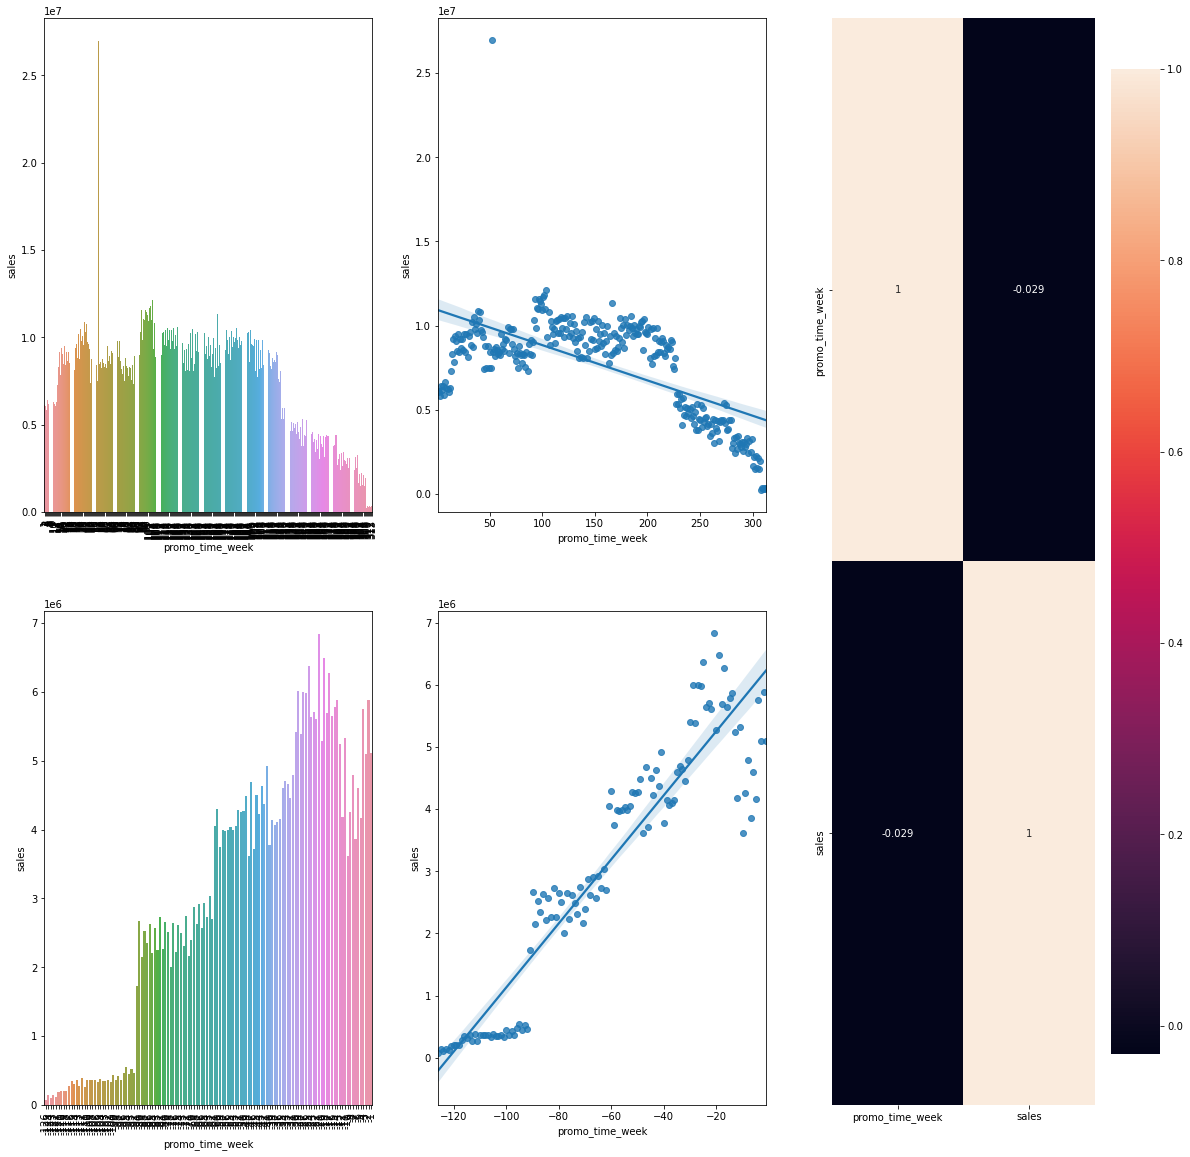

In [37]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = gridspec.GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendida
sns.barplot( x='promo_time_week', y='sales',data=aux2);
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot( x='promo_time_week', y='sales',data=aux2);

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot( x='promo_time_week', y='sales',data=aux3);
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot( x='promo_time_week', y='sales',data=aux3);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### <s>**H5.** <s>Lojas com mais dias de promoção deveriam vender mais.</s>

### **H6.** Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA** Lojas com mais promocoes consecutivas vendem menos.

In [38]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


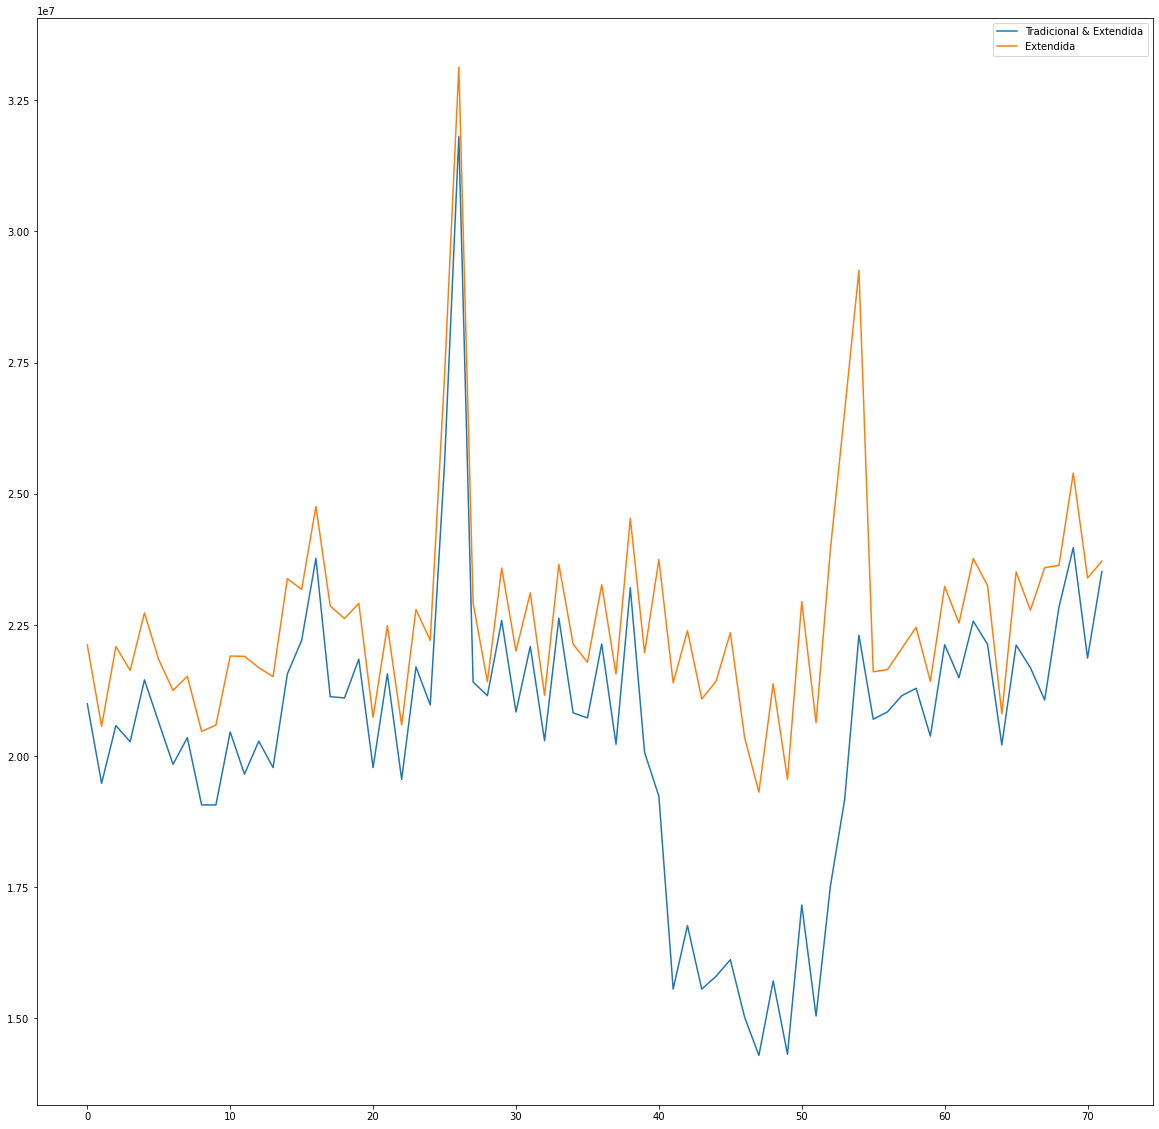

In [39]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional & Extendida', 'Extendida']);

### **H7.** Lojas abertas durante feriado de Natal deveriam vender mais.
**FALSA** Lojas abertas durante o feriado do Natal vendem MENOS.

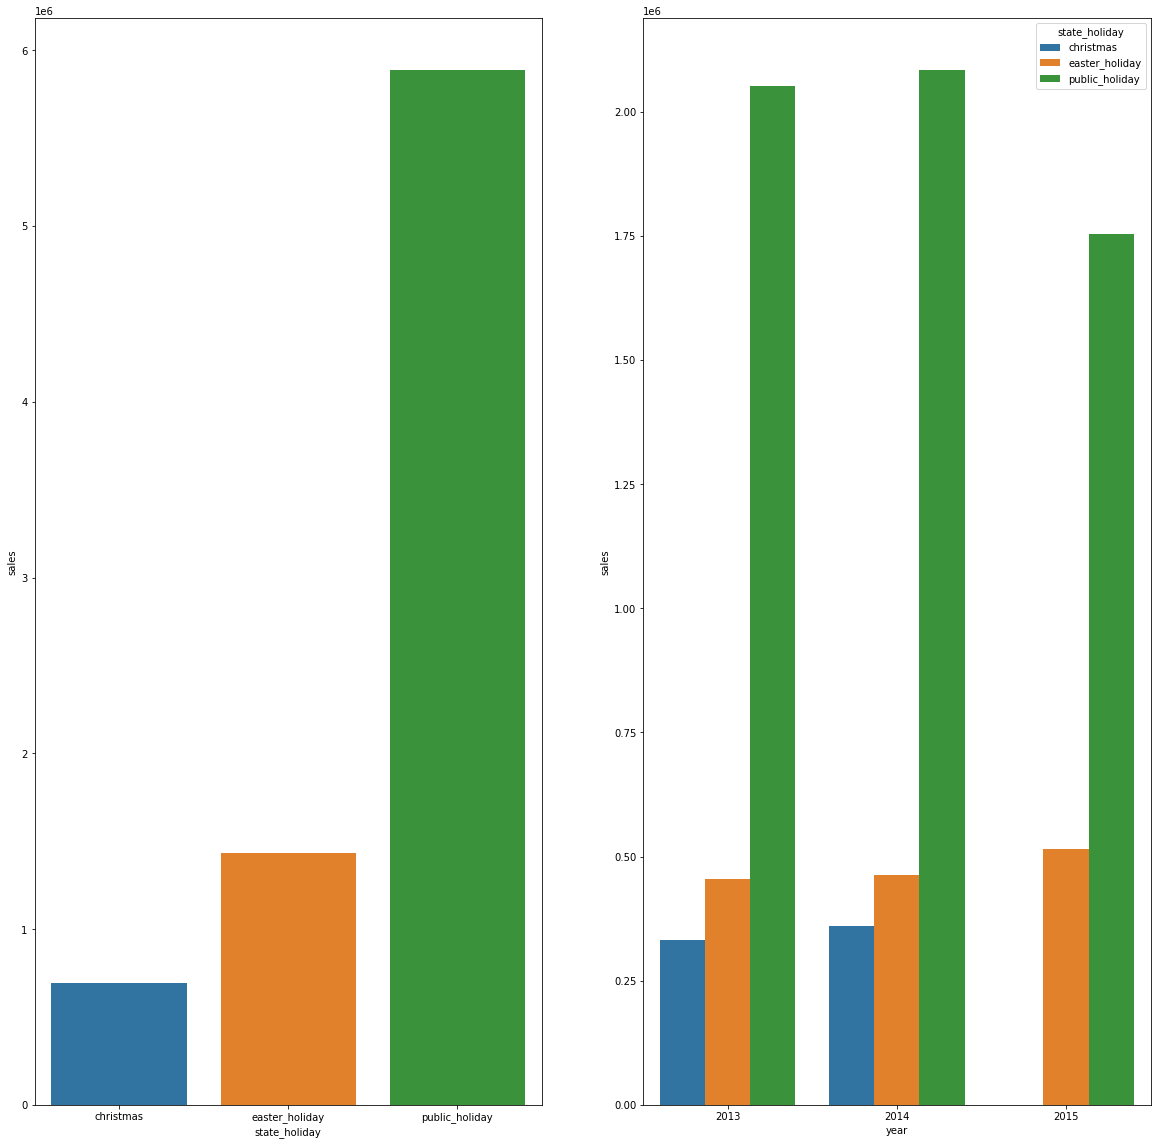

In [40]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday').sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1);

plt.subplot(1, 2, 2)
aux2 = aux[['year', 'state_holiday','sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2);

### **H8.** Lojas deveriam vender mais ao longo dos anos.
**FALSA** Lojas vendem menos ao longo dos anos.

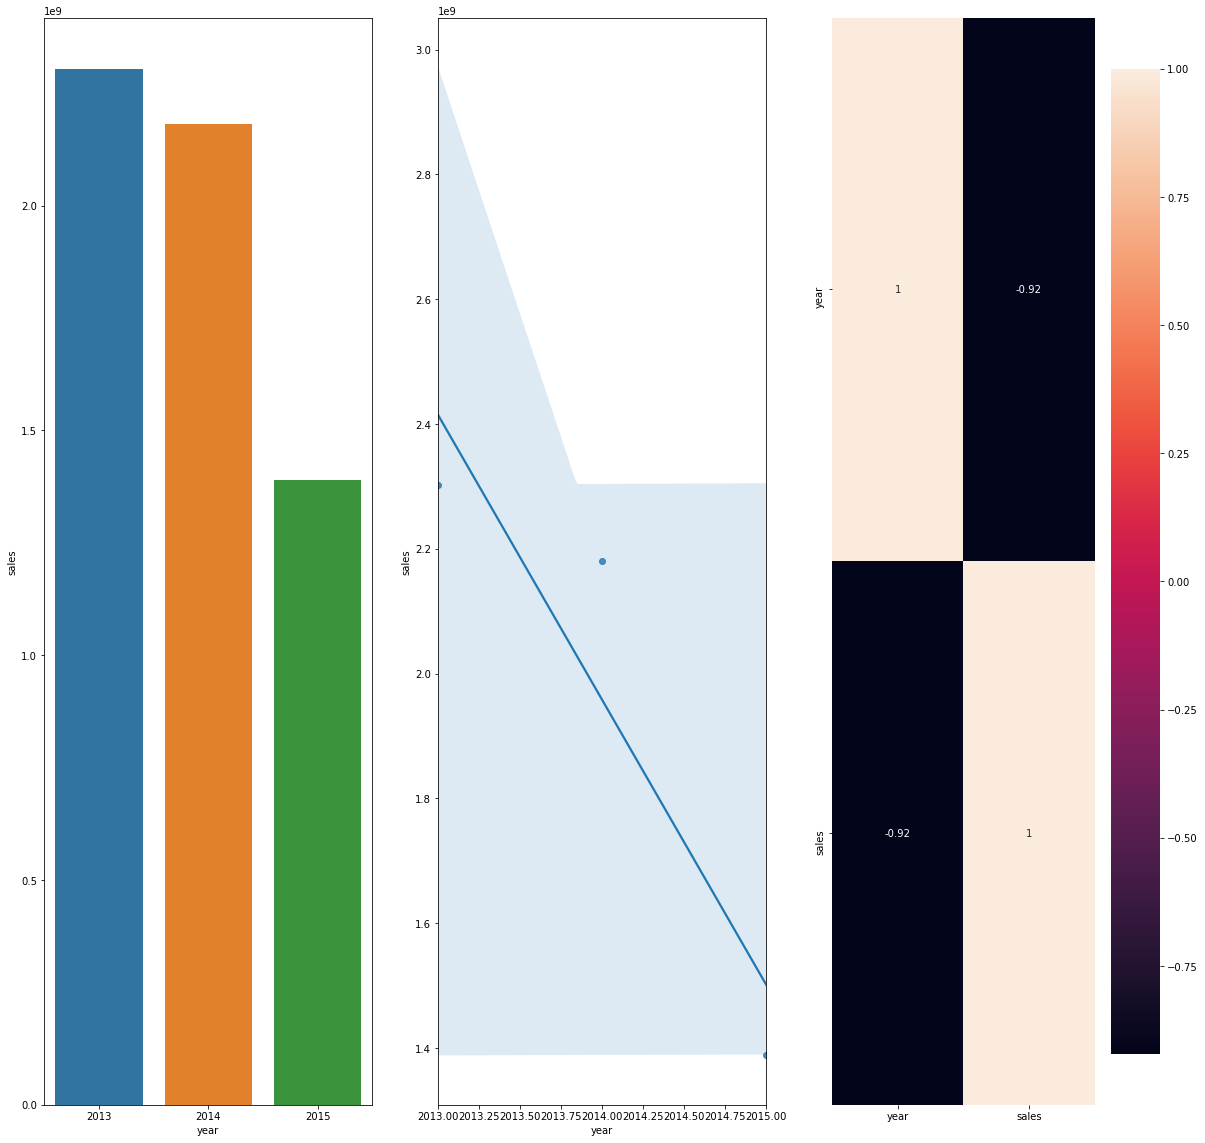

In [41]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H9.** Lojas deveriam vender mais no segundo semestre do ano.
**FALSA** Lojas vendem menos no segundo semestre do ano.

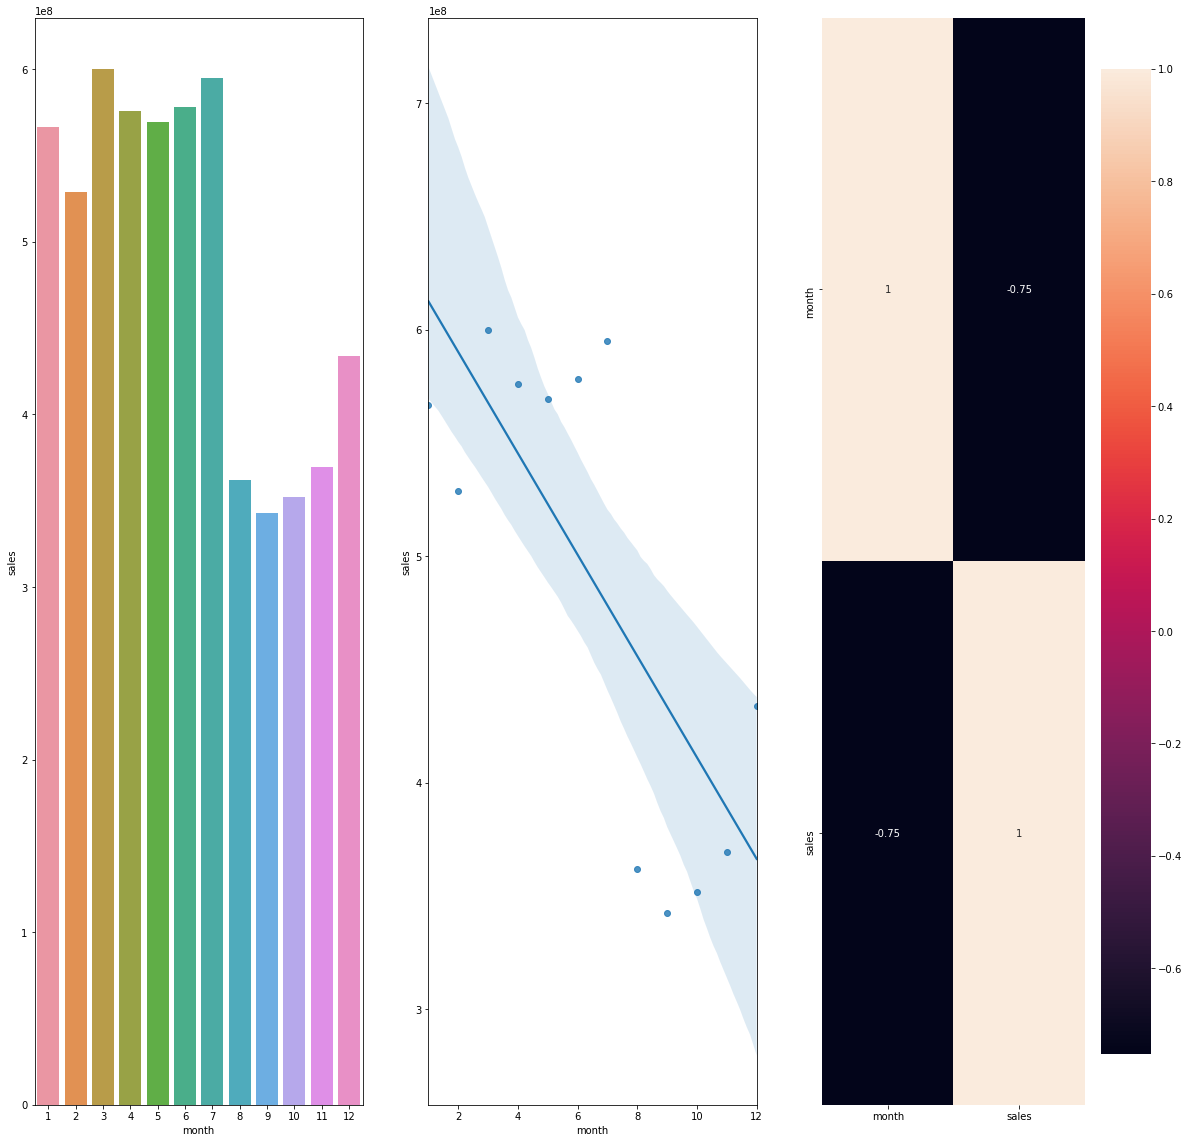

In [42]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H10.** Lojas deveriam vender mais depois do dia 10 de cada mês.
**FALSA** Lojas não vendem mais depois do dia 10.

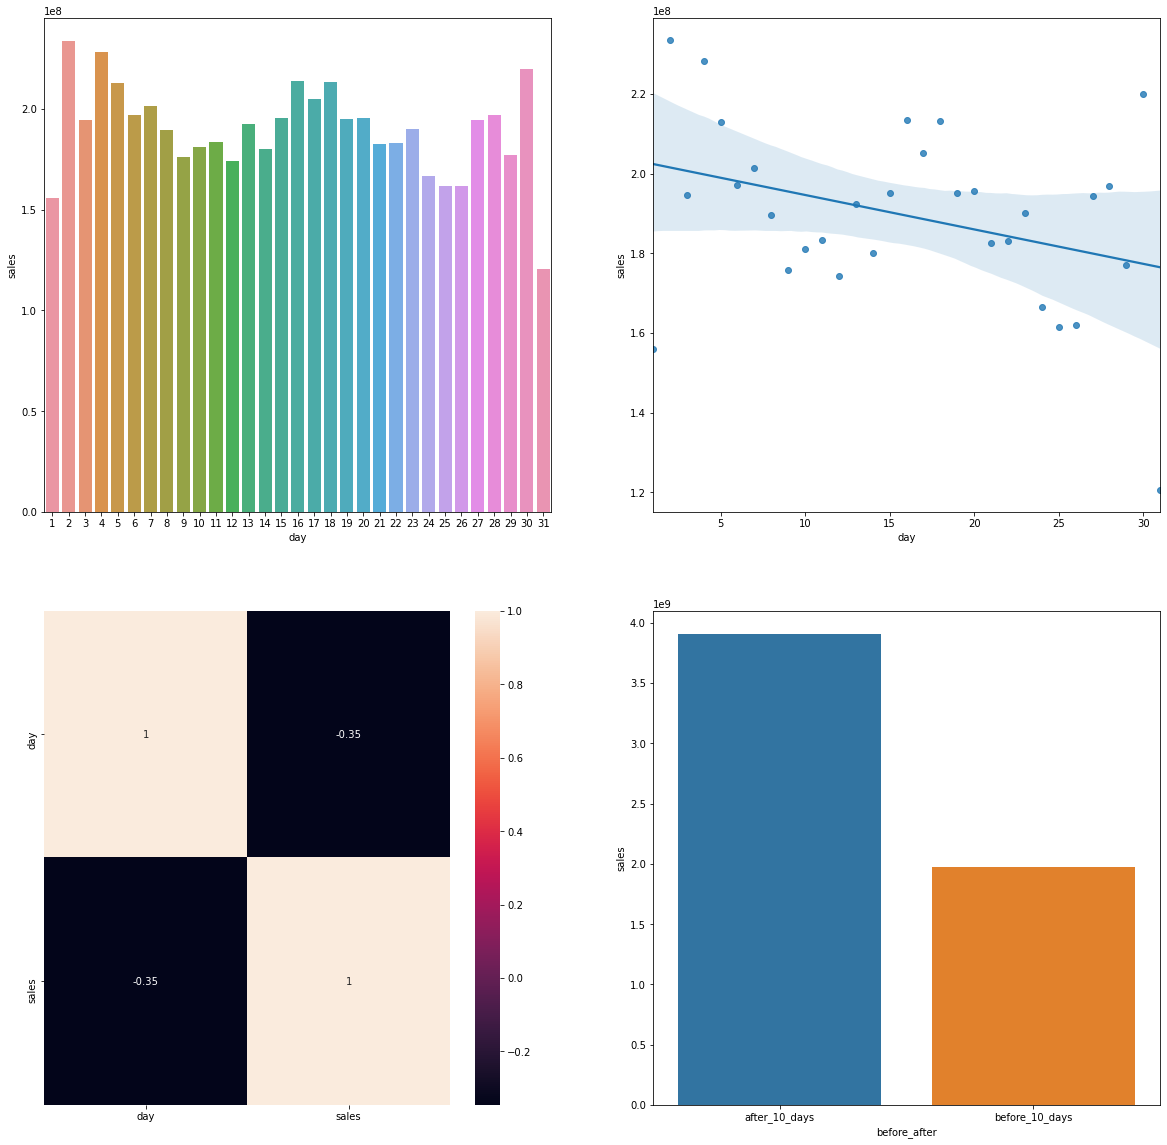

In [43]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data=aux1);

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data=aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x='before_after', y='sales', data=aux2);

### **H11.** Lojas deveriam vender menos aos finais de semana.
**VERDADEIRO** Lojas vendem menos aos finais de semana.

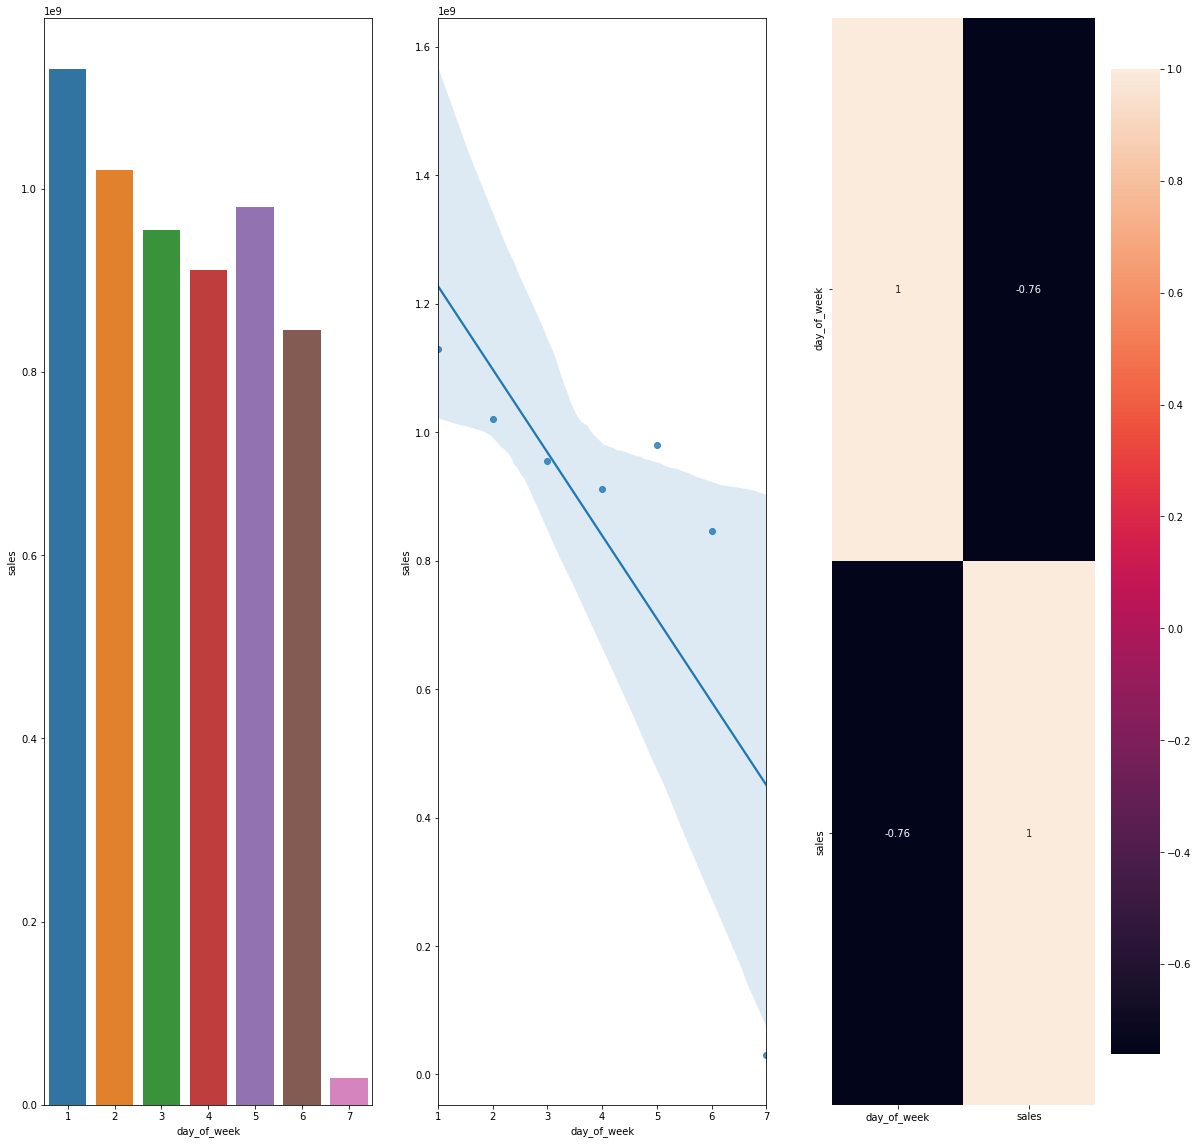

In [44]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H12.** Lojas deveriam vender menos durante os feriados escolares.
**VERDADEIRA** Lojas vendem menos durante os feriados escolares, exceto os meses de Julho (7) e Agosto (8).

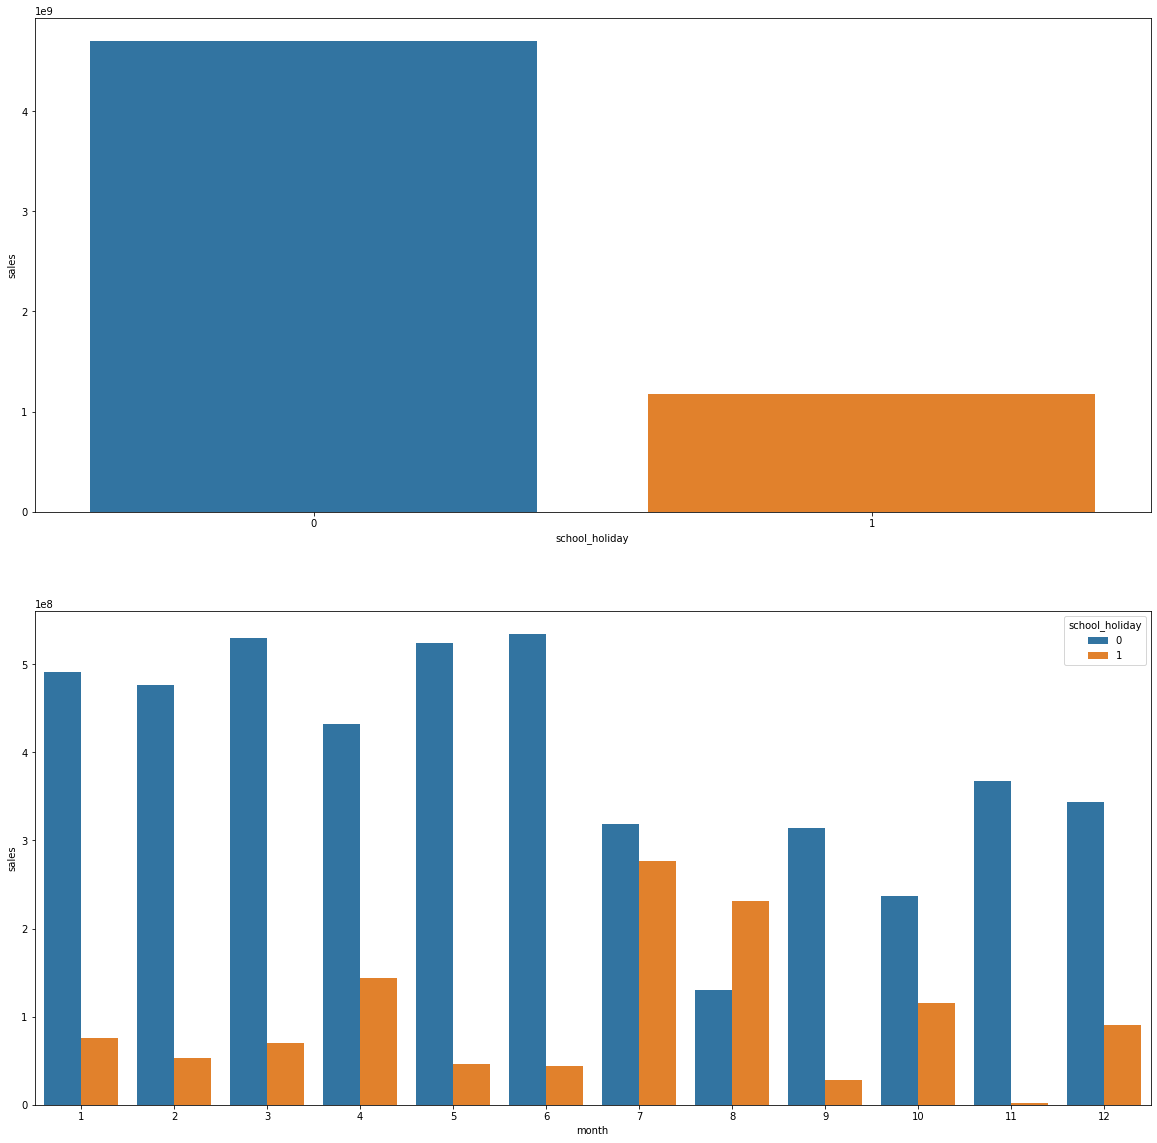

In [45]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
plt.subplot(2,1,1)
sns.barplot( x= 'school_holiday', y='sales', data=aux1);

plt.subplot(2,1,2)
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month','school_holiday']).sum().reset_index()
sns.barplot( x= 'month', y='sales',hue='school_holiday', data=aux2);

## 4.3. Analise Multivariada 

### 4.3.1. Numerical Attributes

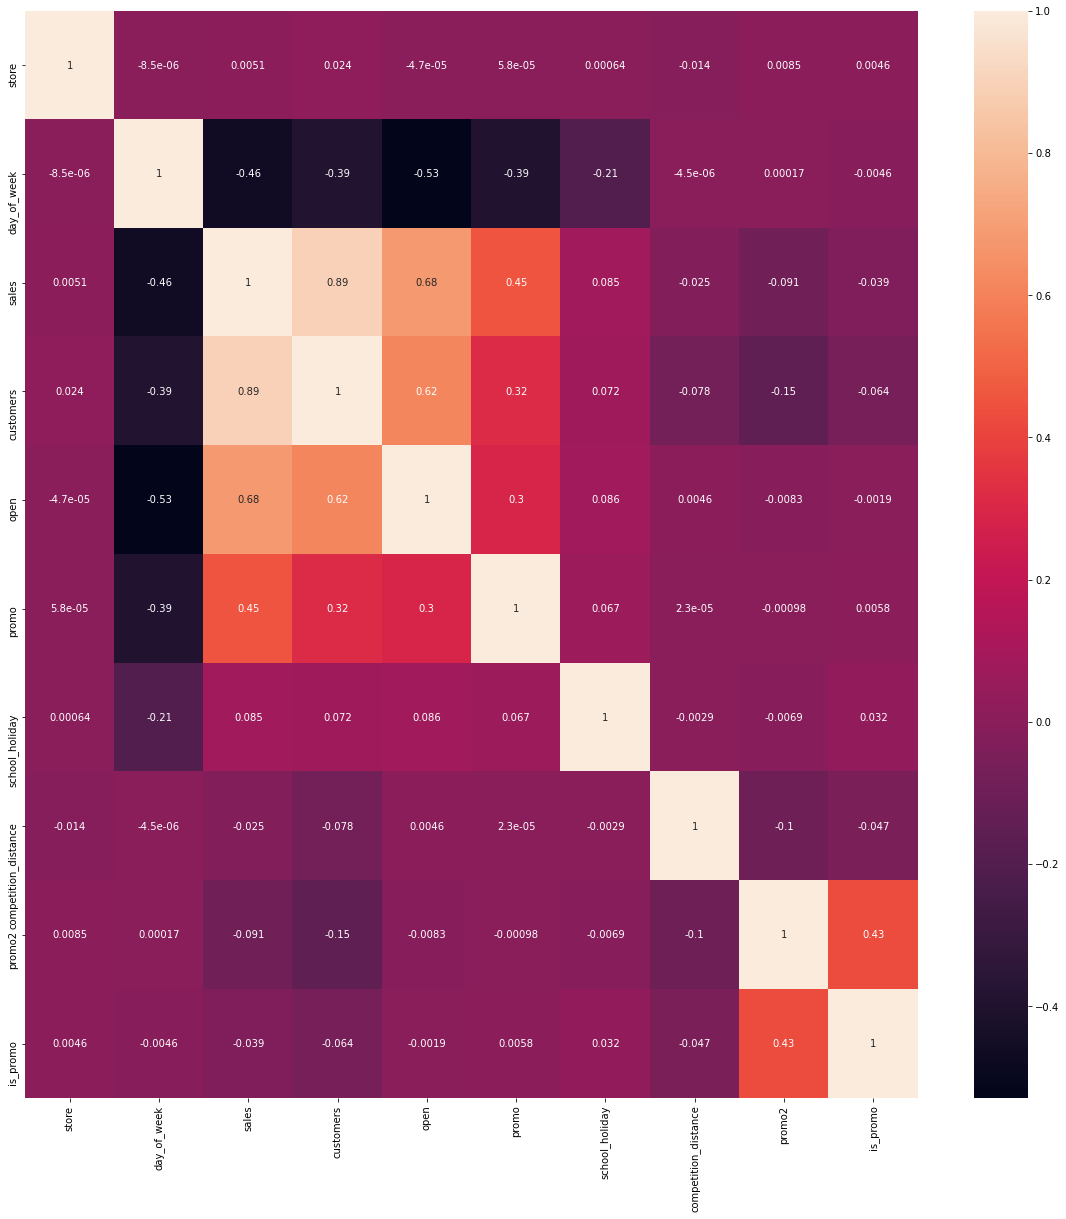

In [46]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

### 4.3.2. Categorical Attributes

<AxesSubplot:>

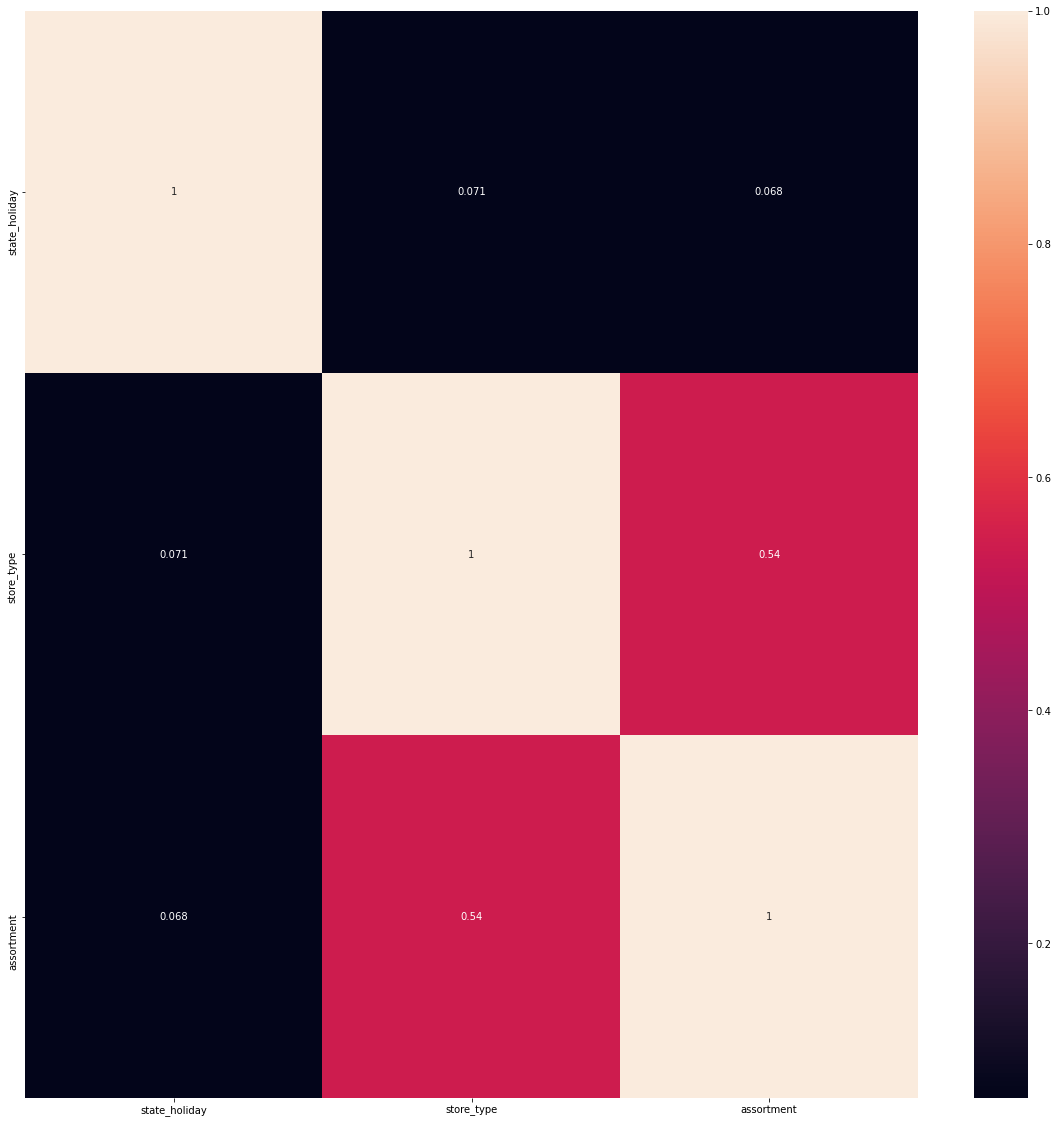

In [47]:
# only categorical data
a = df4.select_dtypes( include='object' )

# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3], 
               'store_type': [a4, a5, a6],
               'assortment': [a7, a8, a9]  })
d = d.set_index( d.columns )

sns.heatmap( d, annot=True )

# 5.0. DATA PREPARATION

In [99]:
df5 = df4.copy()

## 5.1. Normalizacao

## 5.2. Rescaling

In [100]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values )
pickle.dump(rs, open('parameter/competition_distance_scaler.pkl','wb'))

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values )
pickle.dump(rs, open('parameter/competition_time_month_scaler.pkl','wb'))


# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values )
pickle.dump(rs, open('parameter/competition_time_week_scaler.pkl','wb'))


# year
df5['year'] = mms.fit_transform(df5[['year']].values )
pickle.dump(mms, open('year_scaler.pkl','wb'))

## 5.3. Transformacao

### 5.3.1. Encoding

In [98]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
pickle.dump(le, open('parameter/store_type_scaler.pkl', 'wb'))

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1.0, 'extra': 2.0, 'extended': 3.0}
df5['assortment'] = df5['assortment'].map( assortment_dict )

### 5.3.2. Response Variable Transformation

In [51]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.3. Nature Transformation

In [52]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2. * np.pi/7)))

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2. * np.pi/12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2. * np.pi/30)))

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*(2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*(2. * np.pi/52)))


# 6.0. FEATURE SELECTION

In [53]:
df6 = df5.copy()

### 6.1. Split dataframe into training and test dataset

In [54]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

In [55]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )

print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


### 6.2. Boruta as Feature Selector

In [56]:
## training and test dataset for Boruta
#X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
#y_train_n = y_train.values.ravel()
#
## define RandomForestRegressor
#rf = RandomForestRegressor( n_jobs=-1 )
#
## define Boruta
#boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n )

### 6.2.1. Best Features from Boruta

In [57]:
#cols_selected = boruta.support_.tolist()
#
## best features
#x_train_fs = X_train.drop(['date', 'sales'], axis=1)
#cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()
#
## not selected boruta
#cols_not_selected_boruta = list(np.setdiff1d(x_train_fs.columns, cols_selected_boruta))

#  6.3. Manual Feature Selection

In [58]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']


cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# 7.0. MACHINE LEARNING MODELLING

In [59]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

#Time Series Data Preparation
x_training = X_train[cols_selected_boruta_full]

## 7.1. Average Model

In [60]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store','sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2. Linear Regression Model

In [61]:
# Model
lr = LinearRegression().fit( x_train, y_train )

# Prediction
yhat_lr = lr.predict(x_test)

# Performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1. Linear Regression Model - Cross Validation

In [62]:
lr_result_cv = cross_validation(x_training, 5, 'Linea Regression', lr, verbose=False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linea Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3. Linear Regression Regularized Model - Lasso

In [63]:
# Model
lrr = Lasso(alpha=0.0001).fit( x_train, y_train )

# Prediction
yhat_lrr = lrr.predict(x_test)

# Performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1867.907526,0.291894,2675.988565


### 7.3.1.Lasso - Cross Validation

In [64]:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr, verbose=False)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2081.64 +/- 298.77,0.3 +/- 0.02,2955.91 +/- 471.18


## 7.4. Random Forest Regressor

In [65]:
# Model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit( x_train, y_train )

# Prediction
yhat_rf = rf.predict(x_test)

# Performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.881137,0.099945,1011.628207


### 7.4.1. Random Forest Regressor - Cross Validation

In [66]:
rf_result_cv = cross_validation(x_training, 5, 'Randon Forest Regressor', rf, verbose=True)
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Randon Forest Regressor,836.7 +/- 217.15,0.12 +/- 0.02,1254.34 +/- 316.26


## 7.5. XGBoost Regressor 

In [67]:
# Model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', 
                             n_estimators=100, 
                             eta=0.01, 
                             max_depth=10, 
                             subsample=0.7 
                             ).fit( x_train, y_train )

# Prediction
yhat_xgb = model_xgb.predict(x_test)

# Performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6683.6064,0.949503,7330.742181


### 7.5.1. XGBoost Regressor - Cross Validation

In [68]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,7047.97 +/- 587.65,0.95 +/- 0.0,7714.03 +/- 688.72


## 7.6. Compare Model's Performance 

### 7.6.1. Single Performance

In [69]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.881137,0.099945,1011.628207
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1867.907526,0.291894,2675.988565
0,XGBoost Regressor,6683.606400,0.949503,7330.742181


### 7.6.2. Real Performance - Cross Validation

In [70]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linea Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2081.64 +/- 298.77,0.3 +/- 0.02,2955.91 +/- 471.18
0,Randon Forest Regressor,836.7 +/- 217.15,0.12 +/- 0.02,1254.34 +/- 316.26
0,XGBoost Regressor,7047.97 +/- 587.65,0.95 +/- 0.0,7714.03 +/- 688.72


# 8. HYPERPARAMETER FINE TUNING

## 8.1. Random Search

In [71]:
param = {
    'n_estimators':[15, 12, 17, 30],
    'eta':[0.1, 0.3, 0.03],
    'max_depth':[3, 5, 11],
    'subsample':[0.1, 0.7, 0.14],
    'min_child_weight':[3, 7, 10, 12]
    }        

MAX_EVAL = 2

In [72]:
final_result = pd.DataFrame()
for i in range( MAX_EVAL ):
    # choose values for parameters randomly        
    hp = {k: random.sample(v,1)[0] for k, v in param.items() }
    print(hp)

    # Model
    model_xgb = xgb.XGBRegressor(objective='reg:squarederror', 
                                 n_estimators=hp['n_estimators'], 
                                 eta=hp['eta'], 
                                 max_depth=hp['max_depth'], 
                                 subsample=hp['subsample'],
                                 min_child_weight=hp['min_child_weight']
                                )


    # Performance
    result = cross_validation(x_training, 2, 'XGBoost Regressor', model_xgb, verbose=False)
    final_result = pd.concat([final_result, result])
final_result

final_result = pd.DataFrame()

{'n_estimators': 15, 'eta': 0.1, 'max_depth': 11, 'subsample': 0.14, 'min_child_weight': 3}
{'n_estimators': 17, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.14, 'min_child_weight': 7}


## 8.2. Final model

In [73]:
param_tuned = {
    'n_estimators':17,
    'eta':0.1,
    'max_depth':3,
    'subsample':0.7,
    'min_child_weight':10
    }        


In [74]:
# Model
model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror', 
                                    n_estimators=param_tuned['n_estimators'], 
                                    eta=param_tuned['eta'], 
                                    max_depth=param_tuned['max_depth'], 
                                    subsample=param_tuned['subsample'],
                                    min_child_weight=param_tuned['min_child_weight']
                                    ).fit(x_train, y_train)

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

    # Performance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,5380.895846,0.735565,6123.19013


# 9.0. TRADUCAO E INTERPRETACAO DOS ERROS

In [75]:
df9 = X_test[cols_selected_boruta_full]

# rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

## 9.1. Business Performance

In [76]:
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

#MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAPE'})

# MERGE
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

#order
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [77]:
df92.head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
0,1,59538.242188,56760.356894,62316.127481,2777.885293,0.631234
1,2,56077.785156,52649.184712,59506.385600,3428.600444,0.677659
2,3,56077.785156,50723.400928,61432.169384,5354.384228,0.770996
3,4,62679.953125,54390.816733,70969.089517,8289.136392,0.828298
4,5,54185.519531,51139.047056,57231.992006,3046.472475,0.648453


<AxesSubplot:xlabel='store', ylabel='MAPE'>

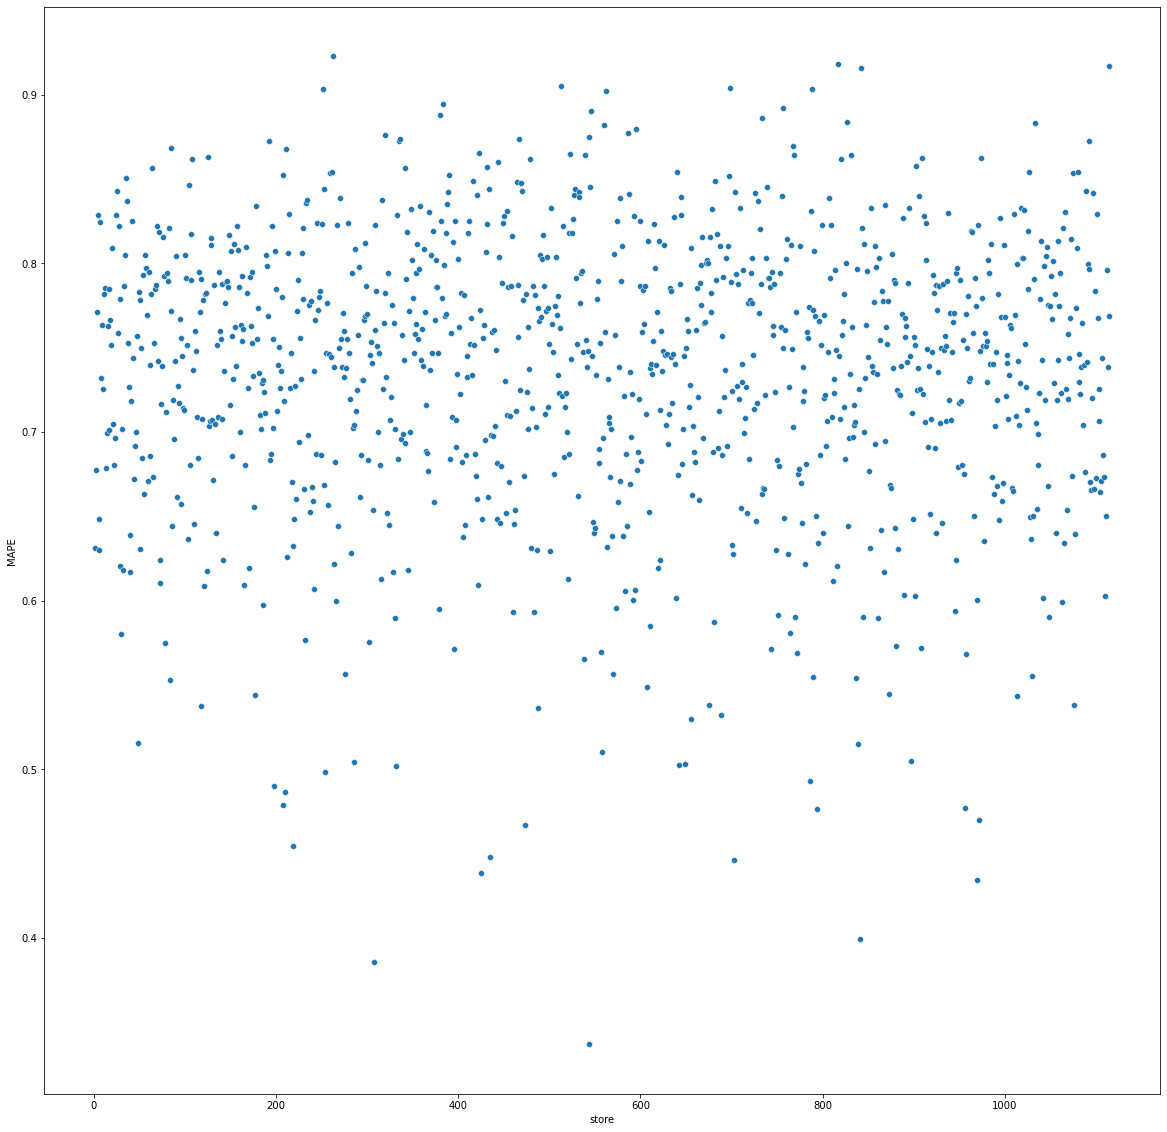

In [78]:
sns.scatterplot(x='store', y='MAPE', data=df92)

## 9.2. Total Performance

In [79]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index': 'Scenario', 0: 'Values'})
df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format)
df93

,Scenario,Values
0,predictions,"R$66,843,620.00"
1,worst_scenario,"R$60,851,176.21"
2,best_scenario,"R$72,836,059.36"


## 9.3. Machine Learning Performance

In [80]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['sales'] / df9['predictions']

<AxesSubplot:xlabel='predictions', ylabel='error'>

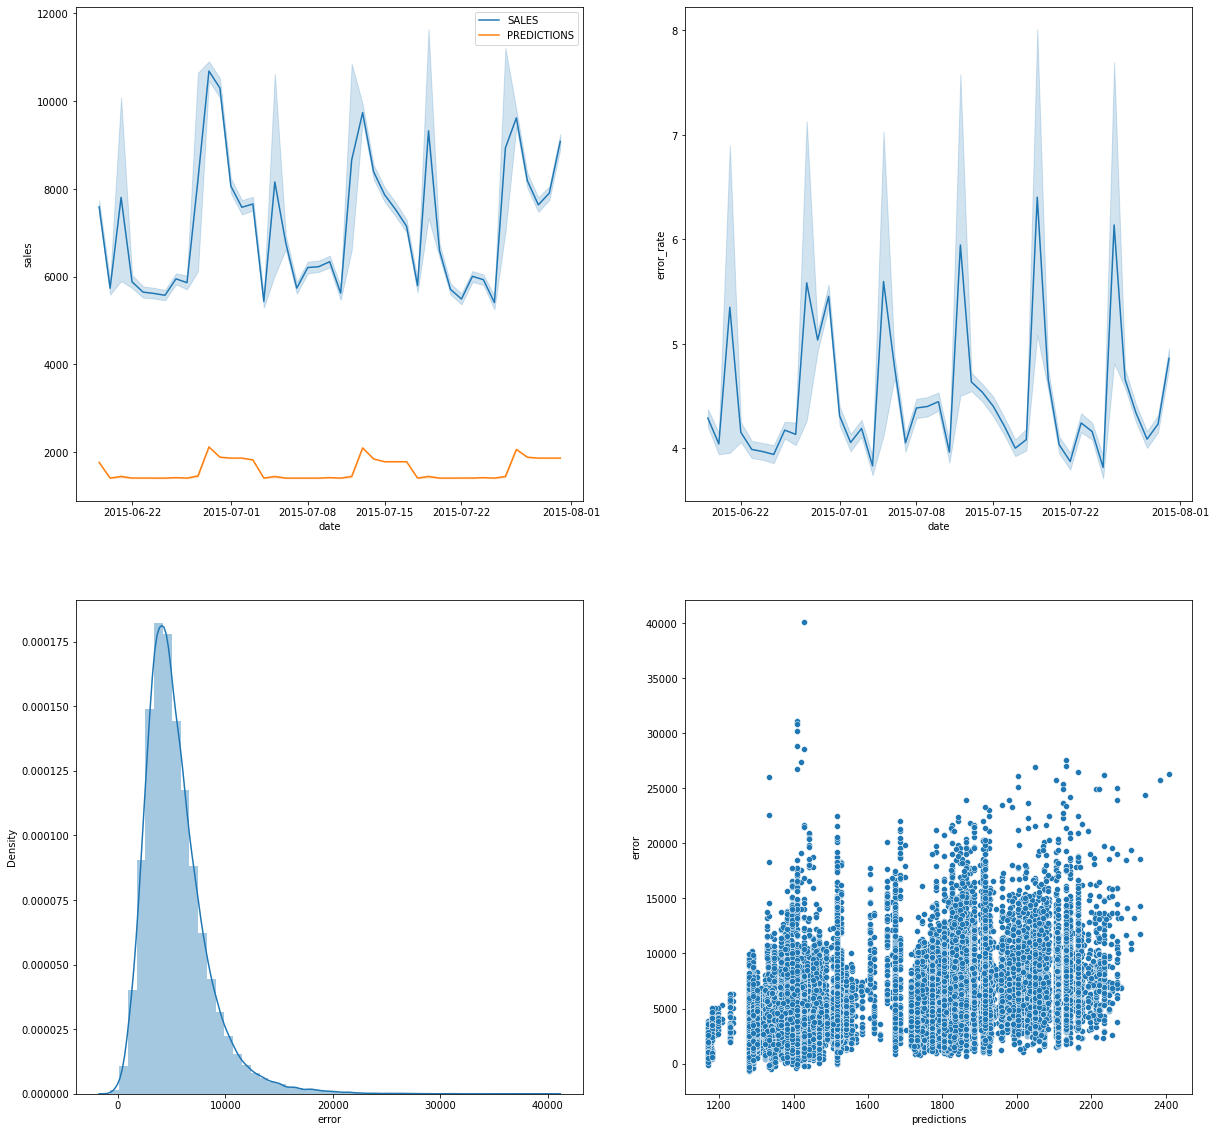

In [81]:
plt.subplot(2,2,1)
sns.lineplot(x='date', y='sales', data=df9, label='SALES')
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS')

plt.subplot(2,2,2)
sns.lineplot(x='date', y='error_rate', data=df9)

plt.subplot(2,2,3)
sns.distplot(df9['error'])

plt.subplot(2,2,4)
sns.scatterplot(df9['predictions'], df9['error'])

# 10.DEPLOY MODEL TO PRODUCTION

In [89]:
# Save Trained Model
pickle.dump(model_xgb_tuned, open('/Users/Henri/repos/DS-em-producao/model/modelo_rossman.pkl', 'wb'))

## 10.1. Rosmann Class

In [ ]:
class Rossmann(object):
    def __init__(self):
        self.competition_distance_scaler   = pickle.load(open('parameter/competition_distance_scaler.pkl','rb'))
        self.competition_time_month_scaler = pickle.load(open('parameter/competition_time_week_scaler.pkl','rb'))
        self.promo_time_week_scaler        = pickle.load(open('parameter/competition_time_month_scaler.pkl','rb'))
        self.year_scaler                   = pickle.load(open('parameter/year_scaler.pkl','rb'))
        self.store_type_scaler             = pickle.load(open('parameter/store_type_scaler.pkl', 'rb'))

        
    def data_cleaning(self, df1):
        ## 1.1 Rename Columns

        cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
                   'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
                   'CompetitionDistance', 'CompetitionOpenSinceMonth',
                   'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
                   'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore(x)

        cols_new = list(map( snakecase, cols_old))

        #rename
        df1.columns = cols_new

        # 1.3 Data Types

        df1['date'] = pd.to_datetime( df1['date'])

        # 1.5. Fillout NA
        #competition_distance 
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

        #competition_open_since_month 
        df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

        #competition_open_since_year     
        df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

        #promo2_since_week  
        df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week']) else x['promo2_since_week'], axis=1)

        #promo2_since_year 
        df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year']) else x['promo2_since_year'], axis=1)

        #promo_interval 
        month_app = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace=True)

        df1['month_map'] = df1['date'].dt.month.map(month_app)

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply (lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

        # 1.6. Change Types

        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)
        
        return df1
    def feature_engineering(self,df2):
        # year
        df2['year'] = df2['date'].dt.year
        # month
        df2['month'] = df2['date'].dt.month
        # day
        df2['day'] = df2['date'].dt.day
        # week of year
        df2['week_of_year'] = df2['date'].dt.isocalendar().week
        #yeah week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

        # competition since
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1), axis=1)
        df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30 ) .apply(lambda x: x.days).astype(int)

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
        df2['promo_since'] = df2['promo_since'].apply (lambda x:datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
        df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

        #assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

        #state holidday
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

        # 3.0. FILTRAGEM DE VARIAVÉIS

        ## 3.1. Filtragem das Linhas

        df2 = df2[(df2['open'] != 0) & (df2['sales'] > 0)]

        ## 3.2. Seleção das Colunas

        cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
        df2 = df2.drop(cols_drop, axis=1)
        
        return df2
    

    def data_preparation(self,df5):
        ## 5.2. Rescaling
        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform(df5[['competition_distance']].values )

        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform(df5[['competition_time_month']].values )


        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform(df5[['promo_time_week']].values )

        # year
        df5['year'] = self.year_scaler.fit_transform(df5[['year']].values )

        ### 5.3.1. Encoding

        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

        # store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.fit_transform( df5['store_type'] )
        

        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 1.0, 'extra': 2.0, 'extended': 3.0}
        df5['assortment'] = df5['assortment'].map( assortment_dict )
        
        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2. * np.pi/7)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2. * np.pi/7)))

        # month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2. * np.pi/12)))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2. * np.pi/12)))

        # day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2. * np.pi/30)))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2. * np.pi/30)))

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*(2. * np.pi/52)))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*(2. * np.pi/52)))
        
        cols_selected = ['store','promo','store_type','assortment','competition_distance','competition_open_since_month','competition_open_since_year','promo2','promo2_since_week','promo2_since_year','competition_time_month','promo_time_week','day_of_week_sin','day_of_week_cos','month_sin','month_cos','day_sin','day_cos','week_of_year_sin','week_of_year_cos']
        
        return df5[cols_selected]

## 10.2. API Handles Class

## 10.3. API Tester